## Libraries

In [1]:
# Required libraries:
# !pip install tensorflow
# !pip install numpy
# !pip install pandas
# !pip install seaborn
# !pip install matplotlib
# !pip install scipy
# !pip install scikit-learn
# !pip install statsmodels

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters
from scipy.signal import find_peaks
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import Ridge
from sklearn.linear_model import BayesianRidge
from sklearn.model_selection import GridSearchCV
from typing import Tuple, List, Dict
from matplotlib.colors import LinearSegmentedColormap
from scipy import signal
from scipy.fft import fft
from statsmodels.tsa.seasonal import STL

## Reading the dataset

The file *Data.csv* contains all the data requiered. However, we are interested in studying the difference between *Up* and *Down* penalties.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

df_clean = pd.read_csv('/content/drive/MyDrive/UNIVERSIDAD/Universidad/Master/Florida Tech/TOPIC-Time series processing/Final project/Data.csv', sep=',')
# df_clean = pd.read_csv('Data.csv', sep=',')
dif_up_down = np.array(df_clean['deviations_up']) - np.array(df_clean['deviations_down'])
print(dif_up_down)

Mounted at /content/drive
[  -6.28   -8.59  -10.62 ... -240.37  157.67  406.4 ]


## EDA

The Exploratory Data Analysis helps get a preview on the trends and tendencies of the data we're analyzing.

#### Correlation matrix

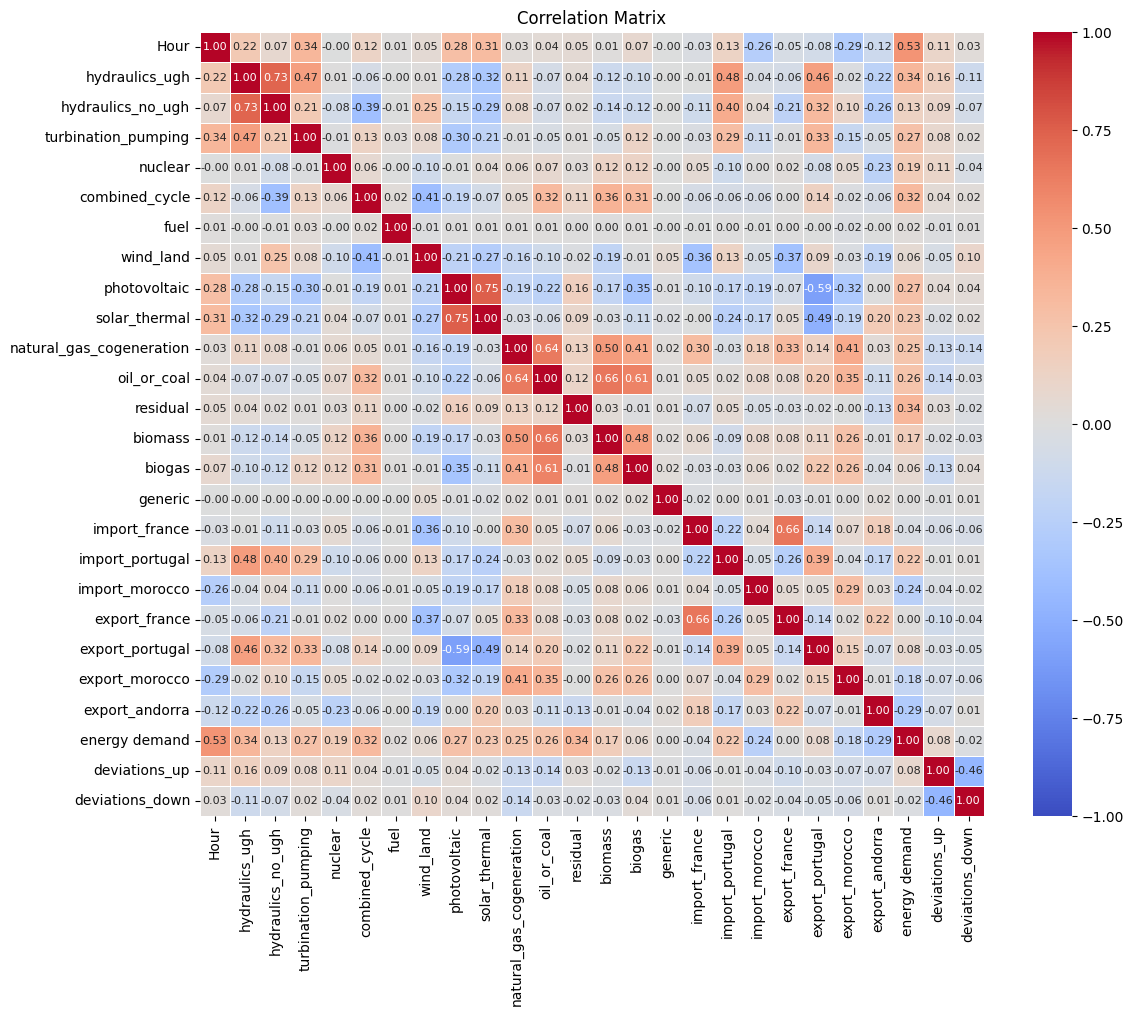

In [3]:
# Exclude the first two columns
df_subset = df_clean.iloc[:, 2:]

# Calculate the correlation matrix
correlation_matrix = df_subset.corr()

# Display the correlation matrix
# print(correlation_matrix)

# Create a better formatted heatmap with improved number visibility
plt.figure(figsize=(12, 10))  # Larger figure size

# Adjust the heatmap for better readability
sns.heatmap(
    correlation_matrix,
    annot=True,              # Show the correlation values
    fmt=".2f",               # Format numbers to 2 decimal places
    cmap='coolwarm',         # Color map
    vmin=-1, vmax=1,         # Set the color scale from -1 to 1
    annot_kws={"size": 8},   # Make the text smaller
    linewidths=0.5,          # Add grid lines
    square=True              # Make cells square-shaped
)

plt.title('Correlation Matrix')
plt.tight_layout()           # Adjust layout to make everything fit
plt.show()

As expected, the correlation between deviations up and deviations down takes negative value (-0.46), meaning we can expect one of these to take low values when the other one is high. Also interesting correlations:


*   Energy exported to Portuagal is low when photovoltaic energy is high. This shows that Portugal also has high photovoltaic energy generation. (Correlation at -0.59)
*   Combined cycle generation high when wind generation low and vice-versa, meaning cycle generation is the key source of generation that substitues wind.(Correlation = -0.41)
*   Negative correlations (-0.28 and -0.28) between solar generation sources and hydraulic generation. Which makes sense, since the rain should affect each differently, and hydraulic plants are always going to prefer to sell their energy when the price is highest, which coincides which when solar energy is lacking.

But regarding he study of penaltie values, perhaps the most interesting yet not too significant correlation (-0.13 and -0.14) between devation penalties values and natural gas cogeneration. Probable cause the stability natural gas power plants supply the grid.

#### Moving averages

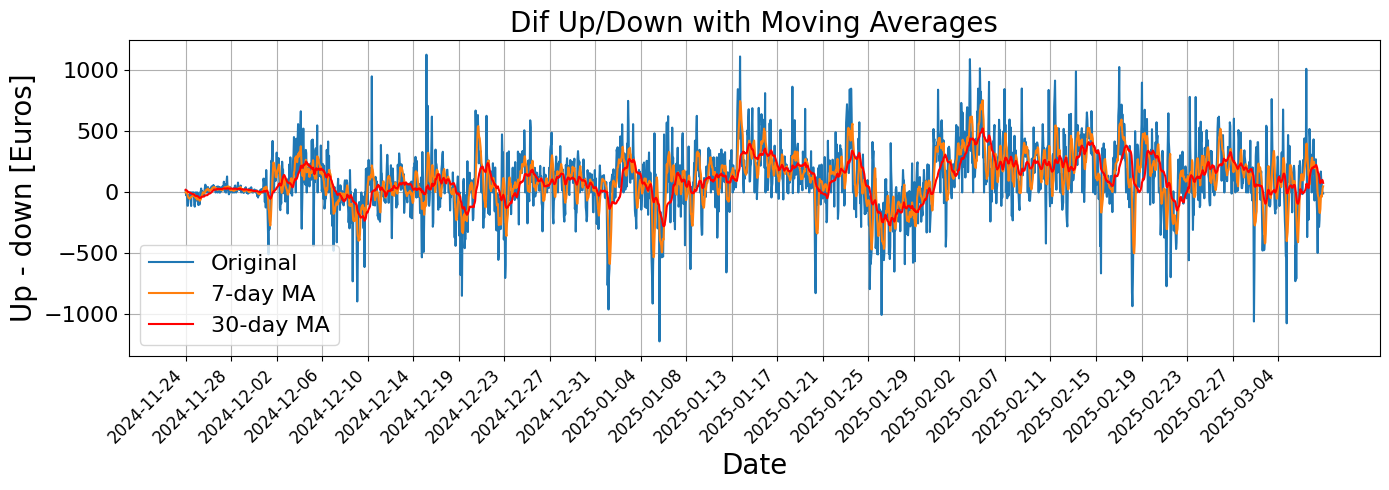

In [4]:
n, m = 3000, 500
tick_step = 100

# Extract date labels
dates = [date[:10] for date in df_clean['Date']]
x = np.arange(len(df_clean['Date']))

# Calculate moving averages
ma_7 = pd.Series(dif_up_down).rolling(window=7).mean()
ma_30 = pd.Series(dif_up_down).rolling(window=30).mean()

plt.figure(figsize=(14, 5))

# Plot original dif_up_down
plt.plot(x[-n:-m], dif_up_down[-n:-m], label='Original', linewidth=1.5)

# Plot moving averages
plt.plot(x[-n:-m], ma_7[-n:-m], label='7-day MA')
plt.plot(x[-n:-m], ma_30[-n:-m], label='30-day MA', color='red')

# Formatting
plt.grid()
plt.xlabel('Date', fontsize=20)
plt.ylabel('Up - down [Euros]', fontsize=20)
plt.xticks(
    ticks=x[-n:-m][::tick_step],
    labels=dates[-n:-m][::tick_step],
    rotation=45,
    ha='right',
    fontsize=12
)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.title('Dif Up/Down with Moving Averages', fontsize=20)
plt.tight_layout()
plt.show()


No clear trend seems clearly visible by studying the moving averages. The high variance is very visible. At first sight, for these 4 months ploted the values seem to be more positive than negative.

### Moving averages - By hour

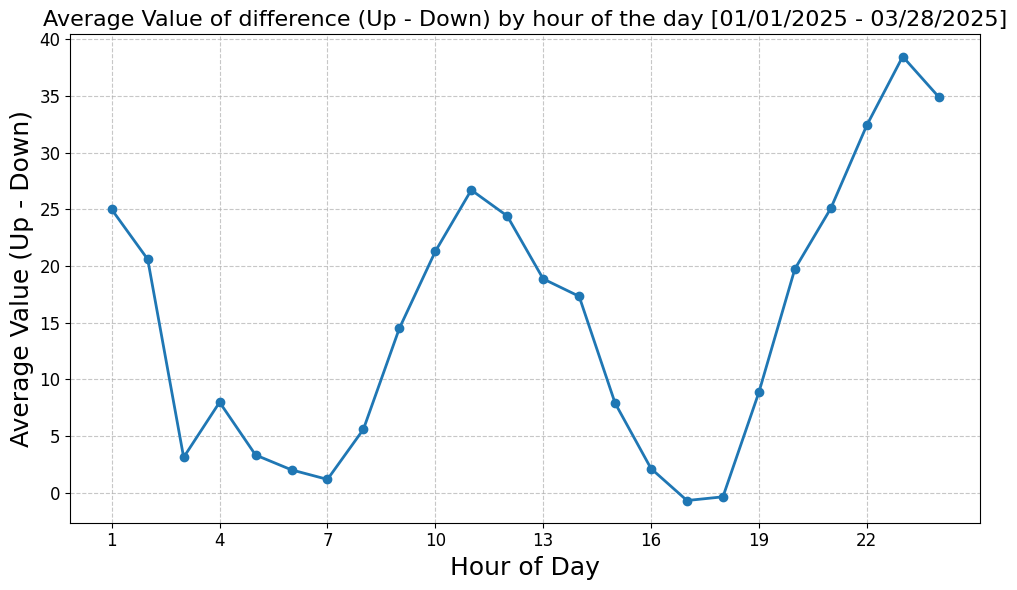

In [5]:
# Step 1: Reshape to organize by day
hours_per_day = 24
num_days = len(dif_up_down) // hours_per_day
data_by_day = dif_up_down[:num_days * hours_per_day].reshape(num_days, hours_per_day)

# Step 2: Calculate the average for each hour across all days
hourly_averages = np.mean(data_by_day, axis=0)

# Step 3: Create the plot
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, 25), hourly_averages, 'o-', linewidth=2, markersize=6)
plt.title('Average Value of difference (Up - Down) by hour of the day [01/01/2025 - 03/28/2025]', fontsize=16)
plt.xlabel('Hour of Day', fontsize=18)
plt.ylabel('Average Value (Up - Down)', fontsize=18)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(np.arange(1, 25, 3), fontsize=12)  # Tick labels with fontsize
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

Contrary to what I experienced during the time I spent working analyzing these back in January 2024 - March 2024 there's a peak during mid-day hours. Surprising, perhaps caused by lack of solar energy during these hours. The high uncertainty in solar generation tends to neutralize the Up-Down difference.

 The peaks during first and last hours are no surprise, has been like since at least 2010 and will almost certainly stay this way. This is provoked by the dissapearence of solar power in these hours. Notice that energy needs to be bought at quiet a high price in these hours, thus companies are going to prefer buying less than predicted therefore saving money there making up for the later penalizations they'll receive. Buying too much energy (at a very high cost) and in addition receiving economical penalties for it would be suicidal for any company.

### STL

Detected potential seasonality periods:
- Autocorrelation suggests period of 24 with strength 0.347
- Autocorrelation suggests period of 12 with strength 0.330
- Spectral analysis suggests period of 12 with strength 196311.047
- Spectral analysis suggests period of 515 with strength 96502.623
- Spectral analysis suggests period of 250 with strength 89370.116

Analyzing data with top 2 detected periods: [24, 12]

Analyzing data with top 2 detected periods: [24, 12]


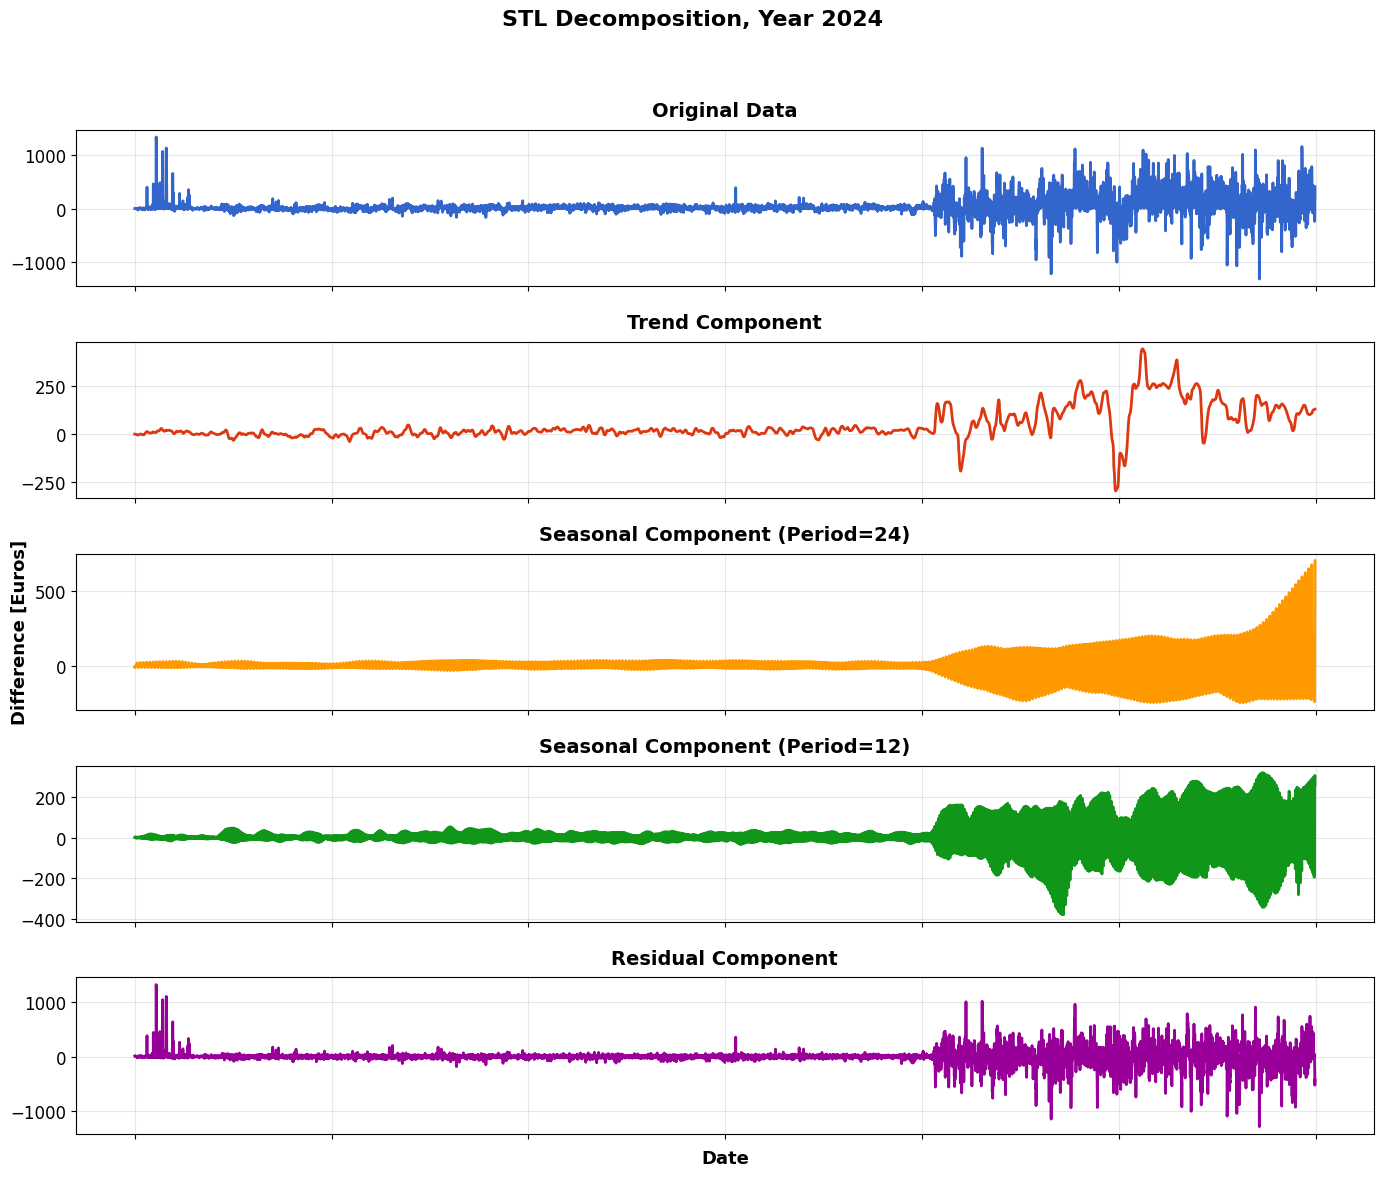

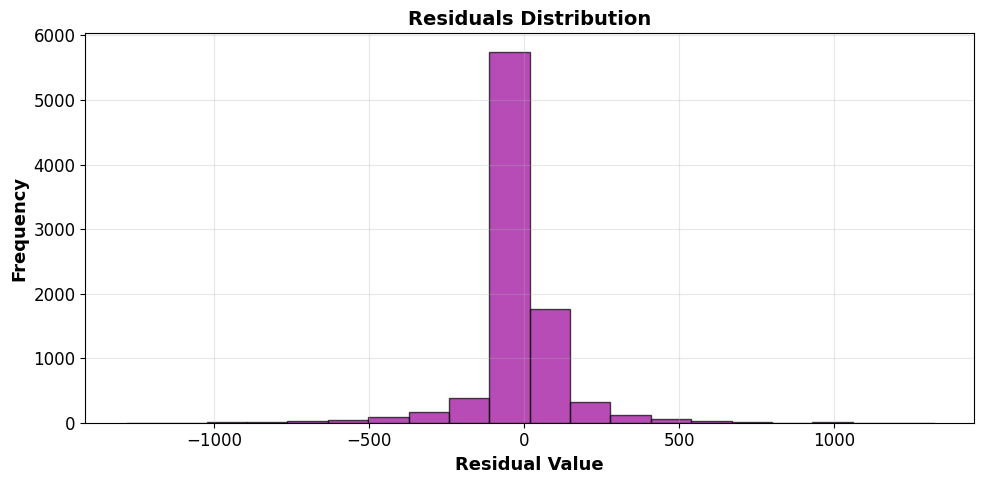


Fit quality metrics:
Period 24: MSE = 17265.8235, Variance explained = 0.3808
Period 12: MSE = 16137.5470, Variance explained = 0.4209

Recommended seasonality period: 12 (best fit to data)


In [6]:
def detect_seasonality(data, max_lag=None):
    """
    Detects potential seasonality periods in the time series using:
    1. Autocorrelation analysis
    2. Spectral analysis (FFT)

    Returns the top candidates from each method.
    """
    if max_lag is None:
        max_lag = len(data) // 2

    results = []

    # Method 1: Autocorrelation analysis
    autocorr = np.correlate(data - np.mean(data), data - np.mean(data), mode='full')
    autocorr = autocorr[len(autocorr)//2:] / np.max(autocorr)

    # Find peaks in autocorrelation
    peaks, _ = signal.find_peaks(autocorr, height=0.3)  # Adjust threshold as needed
    peak_heights = autocorr[peaks]

    # Sort peaks by height and exclude the first peak (lag 0)
    sorted_peaks = sorted([(peaks[i], peak_heights[i]) for i in range(len(peaks)) if peaks[i] > 0],
                          key=lambda x: x[1], reverse=True)

    if sorted_peaks:
        for p, h in sorted_peaks[:3]:  # Show top 3 candidates
            results.append(f"Autocorrelation suggests period of {p} with strength {h:.3f}")

    # Method 2: Spectral analysis using FFT
    n = len(data)
    fft_values = np.abs(fft(data - np.mean(data)))[:n//2]
    frequencies = np.fft.fftfreq(n)[:n//2]

    # Find peaks in spectrum
    peaks, _ = signal.find_peaks(fft_values, height=np.max(fft_values)*0.2)  # Adjust threshold
    peak_heights = fft_values[peaks]

    # Convert frequency peaks to periods
    periods = [int(round(1/abs(frequencies[p]))) for p in peaks if frequencies[p] > 0]
    periods_with_heights = [(periods[i], peak_heights[i]) for i in range(len(periods))]

    # Sort by peak height and keep within reasonable range
    sorted_periods = sorted([(p, h) for p, h in periods_with_heights if p < max_lag],
                           key=lambda x: x[1], reverse=True)

    if sorted_periods:
        for p, h in sorted_periods[:3]:  # Show top 3 candidates
            results.append(f"Spectral analysis suggests period of {p} with strength {h:.3f}")

    return results

def apply_stl_with_best_periods(data, periods=None):
    """
    Apply STL decomposition using the provided periods.
    If periods is None, automatically detect the best period.
    """
    # Convert to pandas Series with datetime index
    ts = pd.Series(data, index=pd.date_range(start='2020-01-01', periods=len(data), freq='D'))

    if periods is None or len(periods) == 0:
        # Detect potential periods
        candidates = detect_seasonality(data)
        print("Detected potential seasonality periods:")
        for candidate in candidates:
            print(f"- {candidate}")

        # Default to first detected period, or 12 if nothing detected
        if candidates and len(candidates) > 0:
            # Extract the first number from the first candidate
            for candidate in candidates:
                try:
                    period = int(''.join(filter(str.isdigit, candidate.split(' with ')[0])))
                    break
                except:
                    period = 12
        else:
            period = 12

        print(f"Using primary period of {period}")
        periods = [period]

    results = []

    # Apply STL for each period
    for period in periods:
        # Ensure seasonal is an odd positive integer >= 3
        seasonal_length = max(3, period + 1)
        if seasonal_length % 2 == 0:  # If even, add 1 to make it odd
            seasonal_length += 1

        stl = STL(ts, seasonal=seasonal_length, period=period, trend=None, robust=True)
        result = stl.fit()

        results.append({
            'period': period,
            'seasonal': result.seasonal,
            'trend': result.trend,
            'resid': result.resid,
            'result': result
        })

    return results

def plot_stl_results(data, results):
    """
    Plot the STL decomposition results in a vertical stack:
    1. Original data
    2. Trend
    3. Seasonality 1
    4. Seasonality 2
    5. Residuals
    """
    # Use 2024 as the year for the date range
    ts = pd.Series(data, index=pd.date_range(start='2024-01-01', periods=len(data), freq='D'))

    # Define colors for each plot
    colors = ['#3366CC', '#DC3912', '#FF9900', '#109618', '#990099']

    # Increase font size for all text elements
    plt.rcParams.update({
        'font.size': 12,
        'axes.titlesize': 14,
        'axes.labelsize': 13,
        'xtick.labelsize': 12,
        'ytick.labelsize': 12,
        'legend.fontsize': 12,
    })

    # Create a vertical stack of plots
    fig, axes = plt.subplots(5, 1, figsize=(14, 12), sharex=True)

    # Add a main title to the figure
    fig.suptitle('STL Decomposition, Year 2024', fontsize=16, fontweight='bold', y=0.98)

    # Component names for the plots
    component_names = ['Original Data', 'Trend Component',
                      f'Seasonal Component (Period={results[0]["period"]})',
                      f'Seasonal Component (Period={results[1]["period"]})',
                      'Residual Component']

    # Create the plots
    data_arrays = [
        ts.values,
        results[0]['trend'].values,
        results[0]['seasonal'].values,
        results[1]['seasonal'].values,
        results[0]['resid'].values
    ]

    # Plot each component
    for i, (name, data_array) in enumerate(zip(component_names, data_arrays)):
        axes[i].plot(ts.index, data_array, color=colors[i], linewidth=2)
        axes[i].set_title(name, fontweight='bold', pad=10)

        # Only show x-axis ticks for the bottom plot
        if i < 4:
            axes[i].set_xticklabels([])
            axes[i].xaxis.label.set_visible(False)
        else:
            axes[i].set_xlabel('Date', fontweight='bold')

        # Add gridlines
        axes[i].grid(True, alpha=0.3)

        # Add y-axis label only to the middle plot to serve as a common label
        if i == 2:
            axes[i].set_ylabel('Difference [Euros]', fontweight='bold')

    # Add more space between subplots
    plt.subplots_adjust(hspace=0.3, top=0.92)

    # Ensure dates are formatted nicely on the bottom plot
    fig.autofmt_xdate()

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave room for the suptitle
    plt.show()

    # Also create a histogram of residuals in a separate figure
    plt.figure(figsize=(10, 5))
    plt.hist(results[0]['resid'].values, bins=20, color=colors[4], alpha=0.7, edgecolor='black')
    plt.title('Residuals Distribution', fontsize=14, fontweight='bold')
    plt.xlabel('Residual Value', fontsize=13, fontweight='bold')
    plt.ylabel('Frequency', fontsize=13, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Sample data
data = dif_up_down[-365*24:] # Take a year

# Detect the best seasonality periods
seasonality_candidates = detect_seasonality(data)
print("Detected potential seasonality periods:")
for candidate in seasonality_candidates:
    print(f"- {candidate}")

# Extract the top two periods from candidates
top_periods = []
for detection_method in [seasonality_candidates[:len(seasonality_candidates)//2],
                        seasonality_candidates[len(seasonality_candidates)//2:]]:
    for candidate in detection_method:
        try:
            period = int(''.join(filter(str.isdigit, candidate.split(' with ')[0])))
            if period not in top_periods and period > 1:  # Avoid duplicates and period 1
                top_periods.append(period)
                break
        except:
            continue

# Make sure we have at least one period
if not top_periods:
    top_periods = [12]  # Default to 12 if nothing detected
elif len(top_periods) == 1:
    # Add a second period that's different from the first
    second_candidates = [7, 12, 24, 30, 52, 365]  # Common seasonality periods
    for p in second_candidates:
        if p != top_periods[0]:
            top_periods.append(p)
            break

print(f"\nAnalyzing data with top {len(top_periods)} detected periods: {top_periods}")

# Make sure we have exactly 2 periods for plotting
if len(top_periods) < 2:
    if top_periods[0] != 7:
        top_periods.append(7)
    else:
        top_periods.append(12)
elif len(top_periods) > 2:
    top_periods = top_periods[:2]

print(f"\nAnalyzing data with top 2 detected periods: {top_periods}")

# Apply STL decomposition with the best periods
stl_results = apply_stl_with_best_periods(data, top_periods)

# Plot the results in the vertical stacked format
plot_stl_results(data, stl_results)

# Calculate and print fit quality metrics
print("\nFit quality metrics:")
for res in stl_results:
    period = res['period']
    resid = res['resid'].values
    mse = np.mean(resid**2)
    variance_explained = 1 - (np.var(resid) / np.var(data))
    print(f"Period {period}: MSE = {mse:.4f}, Variance explained = {variance_explained:.4f}")

# Recommend the best period based on fit quality
best_period_idx = np.argmax([1 - (np.var(res['resid'].values) / np.var(data)) for res in stl_results])
best_period = stl_results[best_period_idx]['period']
print(f"\nRecommended seasonality period: {best_period} (best fit to data)")

So periods 12 and 24 being the most relevant was previsble (the previous plot evidenced it). Since the unit is hours it's leting us know the high variances happen inbetween days and from the day to day. Notice how the predictions need to be made by 12 p.m of the previous day seasonality study is not going to result ver helpful.

And yes, something did happen in October to that affected the penalties so much. In October 14 2024 the [BOE-A-2024-20995](https://www.boe.es/diario_boe/txt.php?id=BOE-A-2024-20995) was published. This resolution adapts the process for the settlement of imbalances in the Spanish electricity system and specifies the implementation of the 15-minute imbalance settlement period (ISP-15), tightening the calculations of imbalance penalties in line with European regulations. In addition, it involves the revision of the system's operational procedures for imbalance settlement, whose tougher approach has a practical and direct impact on the amount of penalties applied to electricity generators. This explains the very visible increase in economical penalties for deviation.

It supposes a huge problem, since it means the data registered before this date will most likely act like noise when trying to train the models. So failure is expected but still worth trying.

### Most influential variables

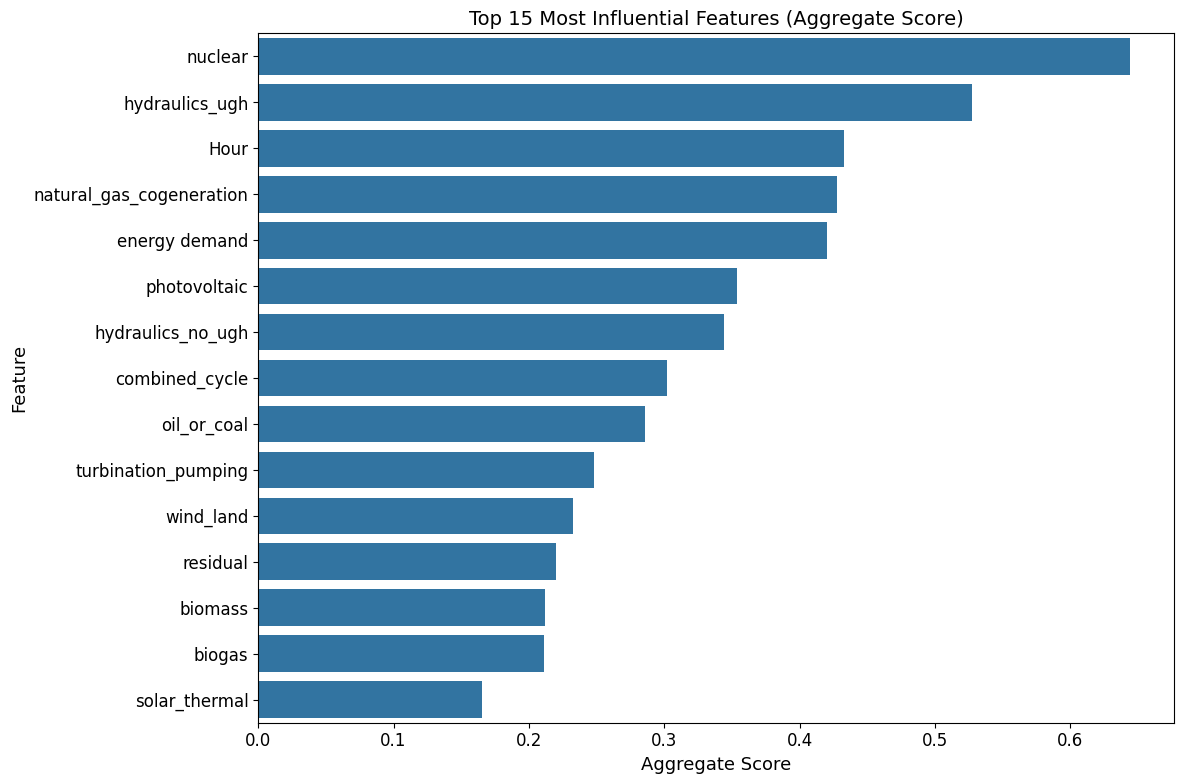

In [7]:
# Assuming your dataframe is called 'df' and the target column is 'target'
# Replace 'target' with your actual target column name
def identify_influential_features(df, target_col):
    # Separate features and target
    X = df.drop(target_col, axis=1)
    y = df[target_col]

    # Handle categorical variables
    X = pd.get_dummies(X)

    # Store feature names for later use
    feature_names = X.columns

    # 1. Correlation Analysis
    correlation = df.corr()[target_col].sort_values(ascending=False)

    # 2. Statistical Tests
    # F-regression for linear relationship
    f_selector = SelectKBest(f_regression, k='all')
    f_selector.fit(X, y)
    f_scores = pd.DataFrame({
        'Feature': feature_names,
        'F Score': f_selector.scores_
    }).sort_values('F Score', ascending=False)

    # Mutual Information for non-linear relationships
    mi_selector = SelectKBest(mutual_info_regression, k='all')
    mi_selector.fit(X, y)
    mi_scores = pd.DataFrame({
        'Feature': feature_names,
        'Mutual Info Score': mi_selector.scores_
    }).sort_values('Mutual Info Score', ascending=False)

    # 3. Model-based feature importance
    # Random Forest importance
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X, y)
    rf_importance = pd.DataFrame({
        'Feature': feature_names,
        'RF Importance': rf.feature_importances_
    }).sort_values('RF Importance', ascending=False)

    # LASSO for sparse feature selection
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    lasso = Lasso(alpha=0.01)
    lasso.fit(X_scaled, y)
    lasso_importance = pd.DataFrame({
        'Feature': feature_names,
        'LASSO Coefficient': np.abs(lasso.coef_)
    }).sort_values('LASSO Coefficient', ascending=False)

    # Combine all scores into one DataFrame
    all_scores = pd.DataFrame({'Feature': feature_names})
    all_scores = all_scores.merge(pd.DataFrame({'Feature': correlation.index.drop(target_col),
                                               'Correlation': correlation.drop(target_col)}),
                                 on='Feature', how='left')
    all_scores = all_scores.merge(f_scores, on='Feature', how='left')
    all_scores = all_scores.merge(mi_scores, on='Feature', how='left')
    all_scores = all_scores.merge(rf_importance, on='Feature', how='left')
    all_scores = all_scores.merge(lasso_importance, on='Feature', how='left')

    # Normalize scores for easier comparison
    for col in all_scores.columns[1:]:
        all_scores[col] = all_scores[col] / all_scores[col].max()

    # Calculate aggregate score (mean of all metrics)
    all_scores['Aggregate Score'] = all_scores.iloc[:, 1:].mean(axis=1)
    all_scores = all_scores.sort_values('Aggregate Score', ascending=False)

    return all_scores, correlation, rf_importance, lasso_importance

# Call the function
df = df_clean.iloc[:, 2:]
df = df.drop('deviations_down', axis=1)
importance_scores, correlation, rf_importance, lasso_importance = identify_influential_features(df, 'deviations_up')

# Visualize the top features
plt.figure(figsize=(12, 8))
sns.barplot(x='Aggregate Score', y='Feature', data=importance_scores.head(15))
plt.title('Top 15 Most Influential Features (Aggregate Score)')
plt.tight_layout()
plt.show()

Not really necessary info to train the models since they already accomodate feauture selection. However, regarding a much debated topic on the importance of nuclear energy, it suggests (it already is a known fact yet debated for some unclear political reason) that nuclear energy is very important source of energy since it provides the electrical grid the stability (inertia) needed to lower the risk of a blackout.

## Scikit

### Lasso

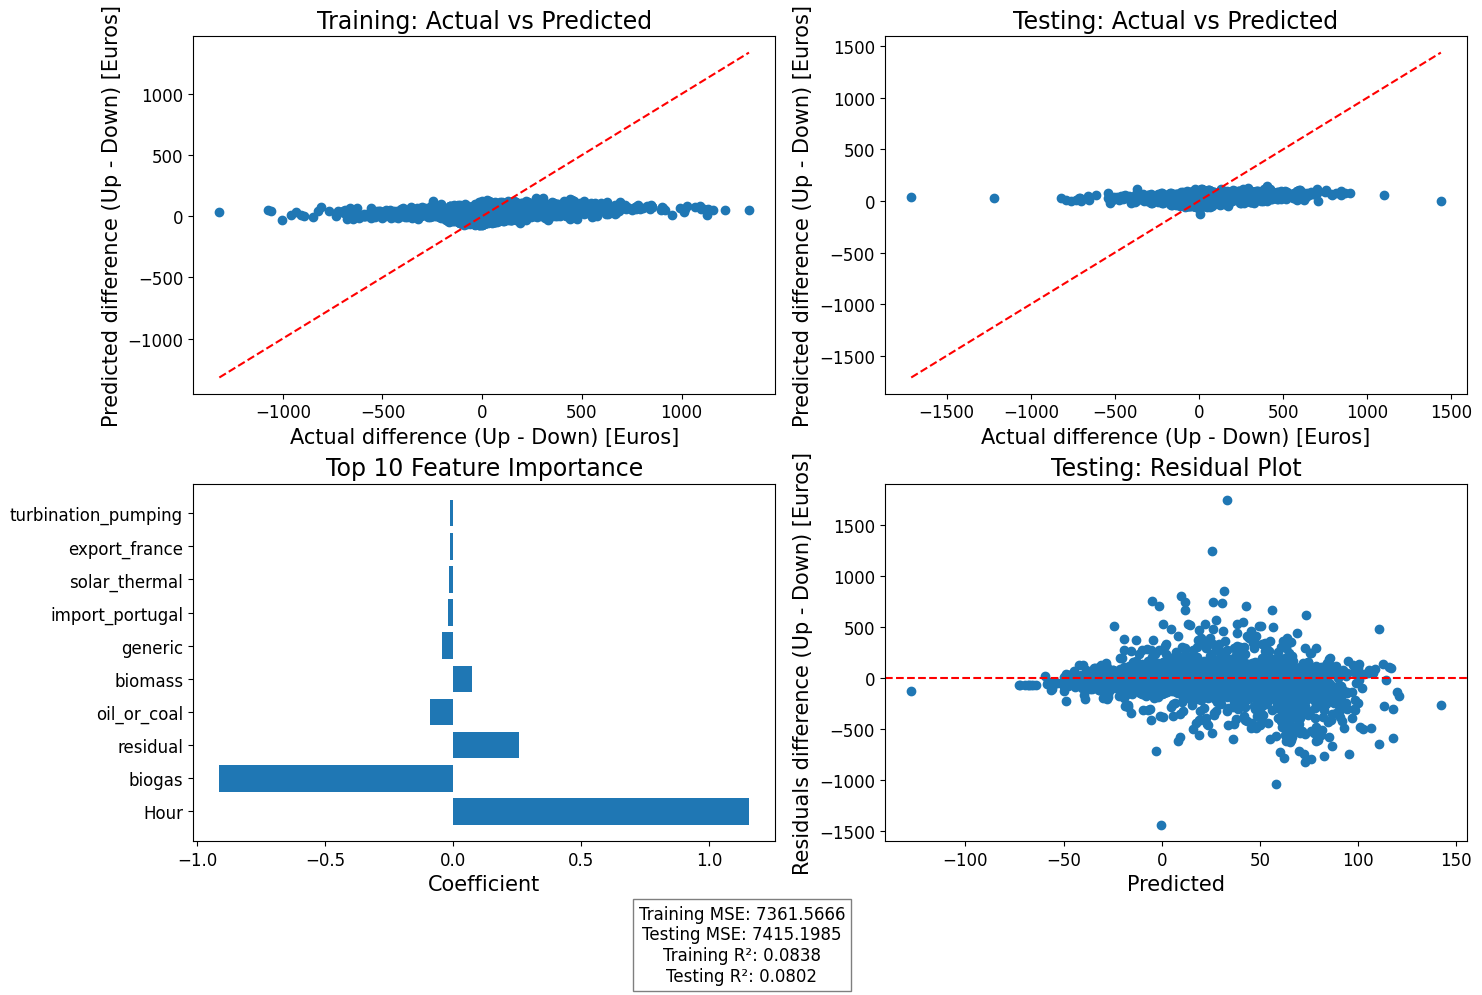

In [8]:
def train_evaluate_lasso(target_values, feature_df, train_percentage=0.7, alpha=1.0, random_state=42):
    """
    Train a LASSO regression model and evaluate its performance.

    Parameters:
    -----------
    target_values : numpy.ndarray
        The target values to predict
    feature_df : pandas.DataFrame
        DataFrame containing the feature variables
    train_percentage : float, default=0.7
        Percentage of data to use for training (between 0 and 1)
    alpha : float, default=1.0
        Regularization strength parameter for LASSO
    random_state : int, default=42
        Random seed for reproducibility

    Returns:
    --------
    dict
        A dictionary containing the trained model, predictions, and evaluation metrics
    """
    # Validate inputs
    if not isinstance(target_values, np.ndarray):
        raise TypeError("target_values must be a numpy array")

    if not isinstance(feature_df, pd.DataFrame):
        raise TypeError("feature_df must be a pandas DataFrame")

    if not 0 < train_percentage < 1:
        raise ValueError("train_percentage must be between 0 and 1")

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        feature_df,
        target_values,
        train_size=train_percentage,
        random_state=random_state
    ) # It should never be donne like this for a time series since this command shuffles the data though. However there are some factors
    # that need to be taken into account that explain why I'm doing this (written in text below)

    # Initialize and train the LASSO model
    lasso_model = Lasso(alpha=alpha, random_state=random_state)
    lasso_model.fit(X_train, y_train)

    # Make predictions
    train_predictions = lasso_model.predict(X_train)
    test_predictions = lasso_model.predict(X_test)

    # Calculate metrics
    train_mse = mean_squared_error(y_train, train_predictions)
    test_mse = mean_squared_error(y_test, test_predictions)
    train_r2 = r2_score(y_train, train_predictions)
    test_r2 = r2_score(y_test, test_predictions)

    # Feature importance (coefficients)
    feature_importance = pd.DataFrame({
        'Feature': feature_df.columns,
        'Coefficient': lasso_model.coef_
    }).sort_values(by='Coefficient', key=abs, ascending=False)

    # Return results
    results = {
        'model': lasso_model,
        'feature_importance': feature_importance,
        'train_predictions': train_predictions,
        'test_predictions': test_predictions,
        'y_train': y_train,
        'y_test': y_test,
        'X_train': X_train,
        'X_test': X_test,
        'metrics': {
            'train_mse': train_mse,
            'test_mse': test_mse,
            'train_r2': train_r2,
            'test_r2': test_r2
        }
    }

    return results, test_predictions, y_test

def plot_lasso_results(results):
    """
    Visualize the results of the LASSO model.

    Parameters:
    -----------
    results : dict
        The dictionary returned by train_evaluate_lasso function
    """
    # Create a figure with subplots
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))

    # Plot 1: Actual vs Predicted (Training)
    axs[0, 0].scatter(results['y_train'], results['train_predictions'])
    axs[0, 0].plot([min(results['y_train']), max(results['y_train'])],
                  [min(results['y_train']), max(results['y_train'])], 'r--')
    axs[0, 0].set_xlabel('Actual difference (Up - Down) [Euros]', fontsize=15)
    axs[0, 0].set_ylabel('Predicted difference (Up - Down) [Euros]', fontsize=15)
    axs[0, 0].set_title('Training: Actual vs Predicted', fontsize=17)

    # Plot 2: Actual vs Predicted (Testing)
    axs[0, 1].scatter(results['y_test'], results['test_predictions'])
    axs[0, 1].plot([min(results['y_test']), max(results['y_test'])],
                  [min(results['y_test']), max(results['y_test'])], 'r--')
    axs[0, 1].set_xlabel('Actual difference (Up - Down) [Euros]', fontsize=15)
    axs[0, 1].set_ylabel('Predicted difference (Up - Down) [Euros]', fontsize=15)
    axs[0, 1].set_title('Testing: Actual vs Predicted', fontsize=17)

    # Plot 3: Feature importance
    top_n = min(10, len(results['feature_importance']))
    top_features = results['feature_importance'].head(top_n)

    axs[1, 0].barh(top_features['Feature'], top_features['Coefficient'])
    axs[1, 0].set_xlabel('Coefficient', fontsize=15)
    axs[1, 0].set_title(f'Top {top_n} Feature Importance', fontsize=17)

    # Plot 4: Residuals
    axs[1, 1].scatter(results['test_predictions'], results['test_predictions'] - results['y_test'])
    axs[1, 1].axhline(y=0, color='r', linestyle='--')
    axs[1, 1].set_xlabel('Predicted', fontsize=15)
    axs[1, 1].set_ylabel('Residuals difference (Up - Down) [Euros]', fontsize=15)
    axs[1, 1].set_title('Testing: Residual Plot', fontsize=17)

    # Add metrics as text
    metrics_text = (
        f"Training MSE: {results['metrics']['train_mse']:.4f}\n"
        f"Testing MSE: {results['metrics']['test_mse']:.4f}\n"
        f"Training R²: {results['metrics']['train_r2']:.4f}\n"
        f"Testing R²: {results['metrics']['test_r2']:.4f}"
    )
    fig.text(0.5, 0.01, metrics_text, ha='center', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.15)
    plt.show()

# Example usage:
if __name__ == "__main__":
    # Train and evaluate the model
    results, predictions_lasso, real_lasso = train_evaluate_lasso(dif_up_down, df_clean.iloc[:, 2:-2], train_percentage=0.7, alpha=0.1)

    # # Print some results
    # print("Model Coefficients:")
    # print(results['feature_importance'])
    # print("\nMetrics:")
    # for name, value in results['metrics'].items():
    #     print(f"{name}: {value:.4f}")

    # Plot results
    plot_lasso_results(results)

**Aclaration:** The following lines of code shuffle the data, which is a wrong approch when handling time series data.

```
# Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        feature_df,
        target_values,
        train_size=train_percentage,
        random_state=random_state
    )
```

But this approach was decided despite seriously affecting the liabilty of the results due to these reasons:


1.   **Regime shift**: As explained earlier, the appliance of a new regulation affects greatly the way penalties are calculated from October 14 on. To contrast this effect we could either only focus on training a model with the previous data, which would be useless, or train a model using only the data from this date on, which is not sufficient.
2.   **Focus on now-casting:** When the variability of the data is so high, and given the need, now-casting is the focus, since you'll need to make the prediction a day in advance.

Thus, shuffling the data is considered, just for the curiosity of the results.

Regardless of the tricks, the results seem very bad. With almost no correlation between predicted values and true values, *R^2 equals 0.082 for test data and 0.0838 for train data*, seems hard to think the model could provide any profit. However, for the applied case, even a slight better performance than random guessing could be considered good due to the complexity of the problem and the fact that most economic loss comes in very few indicated days, where guessing correctly the state of the market could make up for many previous failed days.

### Bayesian Regression

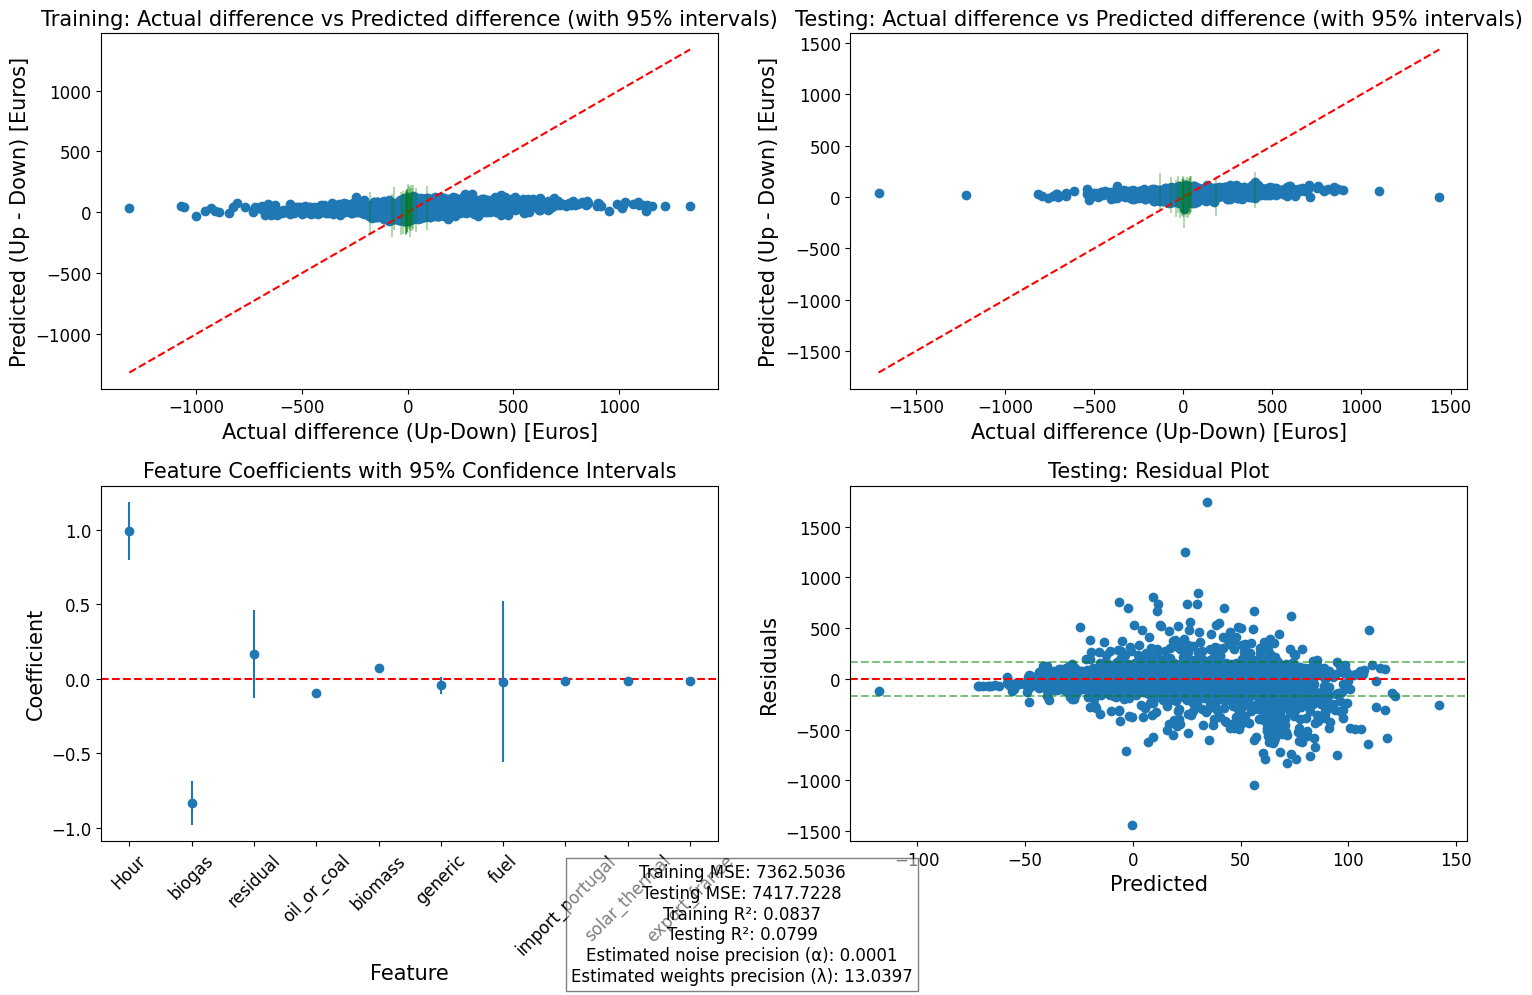

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best parameters:
{'alpha_1': 1e-07, 'alpha_2': 1e-07, 'lambda_1': 1e-05, 'lambda_2': 1e-07}
Best MSE: 8378.5792


In [9]:
def train_evaluate_bayesian_ridge(target_values, feature_df, train_percentage=0.7, random_state=42,
                                  alpha_1=1e-6, alpha_2=1e-6, lambda_1=1e-6, lambda_2=1e-6):
    """
    Train a Bayesian Ridge regression model and evaluate its performance.

    Parameters:
    -----------
    target_values : numpy.ndarray
        The target values to predict
    feature_df : pandas.DataFrame
        DataFrame containing the feature variables
    train_percentage : float, default=0.7
        Percentage of data to use for training (between 0 and 1)
    random_state : int, default=42
        Random seed for reproducibility
    alpha_1 : float, default=1e-6
        First hyperparameter for the gamma distribution prior over the alpha parameter
    alpha_2 : float, default=1e-6
        Second hyperparameter for the gamma distribution prior over the alpha parameter
    lambda_1 : float, default=1e-6
        First hyperparameter for the gamma distribution prior over the lambda parameter
    lambda_2 : float, default=1e-6
        Second hyperparameter for the gamma distribution prior over the lambda parameter

    Returns:
    --------
    dict
        A dictionary containing the trained model, predictions, and evaluation metrics
    """
    # Validate inputs
    if not isinstance(target_values, np.ndarray):
        raise TypeError("target_values must be a numpy array")

    if not isinstance(feature_df, pd.DataFrame):
        raise TypeError("feature_df must be a pandas DataFrame")

    if not 0 < train_percentage < 1:
        raise ValueError("train_percentage must be between 0 and 1")

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        feature_df,
        target_values,
        train_size=train_percentage,
        random_state=random_state
    )

    # Initialize and train the Bayesian Ridge model
    bayesian_model = BayesianRidge(
        alpha_1=alpha_1,
        alpha_2=alpha_2,
        lambda_1=lambda_1,
        lambda_2=lambda_2,
        compute_score=True,
      #  n_iter=300,
        tol=1e-4,
        fit_intercept=True,
       # normalize=False,
        verbose=False
    )

    bayesian_model.fit(X_train, y_train)

    # Make predictions
    train_predictions = bayesian_model.predict(X_train)
    test_predictions = bayesian_model.predict(X_test)

    # Get prediction standard deviations (uncertainty)
    _, train_std = bayesian_model.predict(X_train, return_std=True)
    _, test_std = bayesian_model.predict(X_test, return_std=True)

    # Calculate confidence intervals (95%)
    train_intervals = np.zeros((len(y_train), 2))
    train_intervals[:, 0] = train_predictions - 1.96 * train_std
    train_intervals[:, 1] = train_predictions + 1.96 * train_std

    test_intervals = np.zeros((len(y_test), 2))
    test_intervals[:, 0] = test_predictions - 1.96 * test_std
    test_intervals[:, 1] = test_predictions + 1.96 * test_std

    # Calculate metrics
    train_mse = mean_squared_error(y_train, train_predictions)
    test_mse = mean_squared_error(y_test, test_predictions)
    train_r2 = r2_score(y_train, train_predictions)
    test_r2 = r2_score(y_test, test_predictions)

    # Feature importance (coefficients with standard deviations)
    feature_importance = pd.DataFrame({
        'Feature': feature_df.columns,
        'Coefficient': bayesian_model.coef_,
        'StdDev': np.sqrt(np.diag(bayesian_model.sigma_))
    }).sort_values(by='Coefficient', key=abs, ascending=False)

    # Calculate 95% confidence intervals for coefficients
    feature_importance['Lower_95'] = feature_importance['Coefficient'] - 1.96 * feature_importance['StdDev']
    feature_importance['Upper_95'] = feature_importance['Coefficient'] + 1.96 * feature_importance['StdDev']

    # Return results
    results = {
        'model': bayesian_model,
        'feature_importance': feature_importance,
        'train_predictions': train_predictions,
        'test_predictions': test_predictions,
        'train_intervals': train_intervals,
        'test_intervals': test_intervals,
        'y_train': y_train,
        'y_test': y_test,
        'X_train': X_train,
        'X_test': X_test,
        'metrics': {
            'train_mse': train_mse,
            'test_mse': test_mse,
            'train_r2': train_r2,
            'test_r2': test_r2,
            'noise_precision': bayesian_model.alpha_,
            'weights_precision': bayesian_model.lambda_
        }
    }

    return results, y_test, test_predictions

def plot_bayesian_ridge_results(results):
    """
    Visualize the results of the Bayesian Ridge regression model.

    Parameters:
    -----------
    results : dict
        The dictionary returned by train_evaluate_bayesian_ridge function
    """
    # Create a figure with subplots
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))

    # Plot 1: Actual vs Predicted (Training) with prediction intervals
    axs[0, 0].scatter(results['y_train'], results['train_predictions'])
    axs[0, 0].plot([min(results['y_train']), max(results['y_train'])],
                   [min(results['y_train']), max(results['y_train'])], 'r--')

    # Add prediction intervals for a subset of points (to avoid clutter)
    subset_size = min(20, len(results['y_train']))
    subset_indices = np.random.choice(len(results['y_train']), subset_size, replace=False)

    for i in subset_indices:
        axs[0, 0].plot([results['y_train'][i], results['y_train'][i]],
                       [results['train_intervals'][i, 0], results['train_intervals'][i, 1]],
                       'g-', alpha=0.3)

    # axs[0, 0].set_xlabel('Actual difference (Up-Down) [Euros]')
    # axs[0, 0].set_ylabel('Predicted (Up - Down) [Euros]')
    # axs[0, 0].set_title('Training: Actual vs Predicted (with 95% intervals)')

    axs[0, 0].set_xlabel('Actual difference (Up-Down) [Euros]', fontsize=15)
    axs[0, 0].set_ylabel('Predicted (Up - Down) [Euros]', fontsize=15)
    axs[0, 0].set_title('Training: Actual difference vs Predicted difference (with 95% intervals)', fontsize=15)


    # Plot 2: Actual vs Predicted (Testing) with prediction intervals
    axs[0, 1].scatter(results['y_test'], results['test_predictions'])
    axs[0, 1].plot([min(results['y_test']), max(results['y_test'])],
                   [min(results['y_test']), max(results['y_test'])], 'r--')

    # Add prediction intervals for a subset of points (to avoid clutter)
    subset_size = min(20, len(results['y_test']))
    subset_indices = np.random.choice(len(results['y_test']), subset_size, replace=False)

    for i in subset_indices:
        axs[0, 1].plot([results['y_test'][i], results['y_test'][i]],
                       [results['test_intervals'][i, 0], results['test_intervals'][i, 1]],
                       'g-', alpha=0.3)

    axs[0, 1].set_xlabel('Actual difference (Up-Down) [Euros]', fontsize=15)
    axs[0, 1].set_ylabel('Predicted (Up - Down) [Euros]', fontsize=15)
    axs[0, 1].set_title('Testing: Actual difference vs Predicted difference (with 95% intervals)',fontsize=15)



    # Plot 3: Feature Coefficients with Confidence Intervals
    top_n = min(10, len(results['feature_importance']))
    top_features = results['feature_importance'].head(top_n)

    axs[1, 0].errorbar(
        range(len(top_features)),
        top_features['Coefficient'],
        yerr=[
            top_features['Coefficient'] - top_features['Lower_95'],
            top_features['Upper_95'] - top_features['Coefficient']
        ],
        fmt='o'
    )
    axs[1, 0].axhline(y=0, color='r', linestyle='--')
    axs[1, 0].set_xticks(range(len(top_features)))
    axs[1, 0].set_xticklabels(top_features['Feature'], rotation=45)
    axs[1, 0].set_xlabel('Feature', fontsize=15)
    axs[1, 0].set_ylabel('Coefficient', fontsize=15)
    axs[1, 0].set_title('Feature Coefficients with 95% Confidence Intervals', fontsize=15)

    # Plot 4: Residuals
    axs[1, 1].scatter(results['test_predictions'], results['test_predictions'] - results['y_test'])
    axs[1, 1].axhline(y=0, color='r', linestyle='--')

    # Add prediction intervals to residual plot
    residual_std = np.std(results['test_predictions'] - results['y_test'])
    axs[1, 1].axhline(y=1.96 * residual_std, color='g', linestyle='--', alpha=0.5)
    axs[1, 1].axhline(y=-1.96 * residual_std, color='g', linestyle='--', alpha=0.5)

    axs[1, 1].set_xlabel('Predicted', fontsize=15)
    axs[1, 1].set_ylabel('Residuals', fontsize=15)
    axs[1, 1].set_title('Testing: Residual Plot', fontsize=15)

    # Add metrics as text
    metrics_text = (
        f"Training MSE: {results['metrics']['train_mse']:.4f}\n"
        f"Testing MSE: {results['metrics']['test_mse']:.4f}\n"
        f"Training R²: {results['metrics']['train_r2']:.4f}\n"
        f"Testing R²: {results['metrics']['test_r2']:.4f}\n"
        f"Estimated noise precision (α): {results['metrics']['noise_precision']:.4f}\n"
        f"Estimated weights precision (λ): {results['metrics']['weights_precision']:.4f}"
    )
    fig.text(0.5, 0.01, metrics_text, ha='center', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.15)
    plt.show()

def compare_all_models(target_values, feature_df, train_percentage=0.7, random_state=42):
    """
    Compare Bayesian Ridge, Ridge, and LASSO regression models.

    Parameters:
    -----------
    target_values : numpy.ndarray
        The target values to predict
    feature_df : pandas.DataFrame
        DataFrame containing the feature variables
    train_percentage : float, default=0.7
        Percentage of data to use for training
    random_state : int, default=42
        Random seed for reproducibility

    Returns:
    --------
    dict
        A dictionary containing results from all models
    """

    # Split data once to ensure fair comparison
    X_train, X_test, y_train, y_test = train_test_split(
        feature_df,
        target_values,
        train_size=train_percentage,
        random_state=random_state
    )

    # Train Ridge model
    ridge_model = Ridge(alpha=1.0, random_state=random_state)
    ridge_model.fit(X_train, y_train)
    ridge_train_pred = ridge_model.predict(X_train)
    ridge_test_pred = ridge_model.predict(X_test)
    ridge_train_mse = mean_squared_error(y_train, ridge_train_pred)
    ridge_test_mse = mean_squared_error(y_test, ridge_test_pred)
    ridge_train_r2 = r2_score(y_train, ridge_train_pred)
    ridge_test_r2 = r2_score(y_test, ridge_test_pred)

    # Train LASSO model
    lasso_model = Lasso(alpha=1.0, random_state=random_state)
    lasso_model.fit(X_train, y_train)
    lasso_train_pred = lasso_model.predict(X_train)
    lasso_test_pred = lasso_model.predict(X_test)
    lasso_train_mse = mean_squared_error(y_train, lasso_train_pred)
    lasso_test_mse = mean_squared_error(y_test, lasso_test_pred)
    lasso_train_r2 = r2_score(y_train, lasso_train_pred)
    lasso_test_r2 = r2_score(y_test, lasso_test_pred)

    # Train Bayesian Ridge model
    bayesian_model = BayesianRidge(tol=1e-4) # n_iter=300,
    bayesian_model.fit(X_train, y_train)
    bayesian_train_pred = bayesian_model.predict(X_train)
    bayesian_test_pred = bayesian_model.predict(X_test)
    bayesian_train_mse = mean_squared_error(y_train, bayesian_train_pred)
    bayesian_test_mse = mean_squared_error(y_test, bayesian_test_pred)
    bayesian_train_r2 = r2_score(y_train, bayesian_train_pred)
    bayesian_test_r2 = r2_score(y_test, bayesian_test_pred)

    # Compile results
    comparison_df = pd.DataFrame({
        'Metric': ['Train MSE', 'Test MSE', 'Train R²', 'Test R²'],
        'Ridge': [ridge_train_mse, ridge_test_mse, ridge_train_r2, ridge_test_r2],
        'LASSO': [lasso_train_mse, lasso_test_mse, lasso_train_r2, lasso_test_r2],
        'Bayesian Ridge': [bayesian_train_mse, bayesian_test_mse, bayesian_train_r2, bayesian_test_r2]
    })

    # Get coefficients for all models
    all_coefficients = pd.DataFrame({
        'Feature': feature_df.columns,
        'Ridge': ridge_model.coef_,
        'LASSO': lasso_model.coef_,
        'Bayesian Ridge': bayesian_model.coef_
    })

    # Plot comparison
    fig, ax = plt.subplots(1, 2, figsize=(15, 6))

    # Plot MSE comparison
    index = np.arange(2)
    bar_width = 0.25

    ax[0].bar(index, [ridge_test_mse, ridge_train_mse], bar_width,
              label='Ridge', color='blue', alpha=0.7)
    ax[0].bar(index + bar_width, [lasso_test_mse, lasso_train_mse], bar_width,
              label='LASSO', color='green', alpha=0.7)
    ax[0].bar(index + 2*bar_width, [bayesian_test_mse, bayesian_train_mse],
              bar_width, label='Bayesian Ridge', color='red', alpha=0.7)

    ax[0].set_ylabel('Mean Squared Error')
    ax[0].set_title('MSE Comparison')
    ax[0].set_xticks(index + bar_width)
    ax[0].set_xticklabels(['Test', 'Train'])
    ax[0].legend()

    # Plot R² comparison
    ax[1].bar(index, [ridge_test_r2, ridge_train_r2], bar_width,
              label='Ridge', color='blue', alpha=0.7)
    ax[1].bar(index + bar_width, [lasso_test_r2, lasso_train_r2], bar_width,
              label='LASSO', color='green', alpha=0.7)
    ax[1].bar(index + 2*bar_width, [bayesian_test_r2, bayesian_train_r2],
              bar_width, label='Bayesian Ridge', color='red', alpha=0.7)

    ax[1].set_ylabel('R² Score')
    ax[1].set_title('R² Comparison')
    ax[1].set_xticks(index + bar_width)
    ax[1].set_xticklabels(['Test', 'Train'])
    ax[1].legend()

    plt.tight_layout()
    plt.show()

    # Plot coefficients comparison
    plt.figure(figsize=(12, 8))

    # Get top features by average absolute coefficient value
    avg_abs_coef = np.mean(np.abs(all_coefficients.iloc[:, 1:].values), axis=1)
    top_indices = np.argsort(avg_abs_coef)[-10:] if len(avg_abs_coef) > 10 else range(len(avg_abs_coef))

    width = 0.25
    x = np.arange(len(top_indices))
    top_features = [all_coefficients['Feature'].iloc[i] for i in top_indices]

    plt.bar(x - width, [all_coefficients['Ridge'].iloc[i] for i in top_indices], width, label='Ridge')
    plt.bar(x, [all_coefficients['LASSO'].iloc[i] for i in top_indices], width, label='LASSO')
    plt.bar(x + width, [all_coefficients['Bayesian Ridge'].iloc[i] for i in top_indices], width, label='Bayesian Ridge')

    plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    plt.xlabel('Feature')
    plt.ylabel('Coefficient')
    plt.title('Coefficient Comparison Across Models')
    plt.xticks(x, top_features, rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

    print("Model Comparison:")
    print(comparison_df)

    results = {
        'comparison_df': comparison_df,
        'coefficient_df': all_coefficients,
        'ridge_model': ridge_model,
        'lasso_model': lasso_model,
        'bayesian_model': bayesian_model
    }

    return results

def find_optimal_hyperparameters(target_values, feature_df, train_percentage=0.7, random_state=42):
    """
    Perform a simple grid search to find optimal hyperparameters for Bayesian Ridge regression.

    Parameters:
    -----------
    target_values : numpy.ndarray
        The target values to predict
    feature_df : pandas.DataFrame
        DataFrame containing the feature variables
    train_percentage : float, default=0.7
        Percentage of data to use for training
    random_state : int, default=42
        Random seed for reproducibility

    Returns:
    --------
    dict
        A dictionary containing the best hyperparameters and model
    """

    # Define parameter grid
    param_grid = {
        'alpha_1': [1e-7, 1e-6, 1e-5],
        'alpha_2': [1e-7, 1e-6, 1e-5],
        'lambda_1': [1e-7, 1e-6, 1e-5],
        'lambda_2': [1e-7, 1e-6, 1e-5]
    }

    # Initialize model
    bayesian_model = BayesianRidge(tol=1e-4) # n_iter=300,

    # Initialize grid search
    grid_search = GridSearchCV(
        estimator=bayesian_model,
        param_grid=param_grid,
        cv=5,
        scoring='neg_mean_squared_error',
        verbose=1,
        n_jobs=-1
    )

    # Fit grid search
    grid_search.fit(feature_df, target_values)

    # Print results
    print("Best parameters:")
    print(grid_search.best_params_)
    print(f"Best MSE: {-grid_search.best_score_:.4f}")

    # Train model with best parameters
    best_model = BayesianRidge(**grid_search.best_params_, tol=1e-4) # n_iter=300
    best_model.fit(feature_df, target_values)

    return {
        'best_params': grid_search.best_params_,
        'best_score': -grid_search.best_score_,
        'best_model': best_model,
        'grid_search': grid_search
    }

# Example usage:
if __name__ == "__main__":
    # Train and evaluate the Bayesian Ridge model
    results, real_bayes, predictions_bayes = train_evaluate_bayesian_ridge(dif_up_down, df_clean.iloc[:, 2:-2], train_percentage=0.7)

    # # Print some results
    # print("Model Coefficients (with uncertainty):")
    # print(results['feature_importance'])
    # print("\nMetrics:")
    # for name, value in results['metrics'].items():
    #     print(f"{name}: {value:.4f}")

    # Plot results
    plot_bayesian_ridge_results(results)

    # Compare with other models
    # comparison = compare_all_models(dif_up_down, df_clean.iloc[:, 2:-2])

    # Find optimal hyperparameters
    optimal_params = find_optimal_hyperparameters(dif_up_down, df_clean.iloc[:, 2:-2])

Lasso applies an L1 penalty to the cost function, which can make some coefficients exactly 0, meaning it can have automatic feauture selection. In contrast, Bayessian Regression applies L2 penalty, which doesn't allow for coefficients to equal exactly 0. The results are 0.0837 training R^2 and 0.0799 test R^2, meaning even worst performance than the Lasso model.

## Deep Learning

Data split: Training 55.0%, Validation 15.0%, Test 30.0%
Actual split sizes: Training 20433, Validation 5573, Test 11146
Actual split percentages: Training 55.0%, Validation 15.0%, Test 30.0%


c:\Users\34673\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
639/639 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1.1058 - mae: 0.5771 - val_loss: 0.8780 - val_mae: 0.4594
Epoch 2/100
639/639 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.8760 - mae: 0.4677 - val_loss: 0.8316 - val_mae: 0.4506
Epoch 3/100
639/639 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.7704 - mae: 0.4491 - val_loss: 0.8010 - val_mae: 0.4382
Epoch 4/100
639/639 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.8072 - mae: 0.4478 - val_loss: 0.7821 - val_mae: 0.4291
Epoch 5/100
639/639 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.7965 - mae: 0.4401 - val_loss: 0.7691 - val_mae: 0.4356
Epoch 6/100
639/639 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.7526 - mae: 0.4365 - val_loss: 0.7547 - val_mae: 0.4229
Epoch 7/100
639/639 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.7233 - mae: 0.4271 - val_loss: 0.7384 - val_mae: 0.4215
Epoch 8/100
639/639 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.6754 - mae: 0.4226 - val_loss: 0.7283 - val_mae: 0.4191
Epoch 9/100
639/639 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/

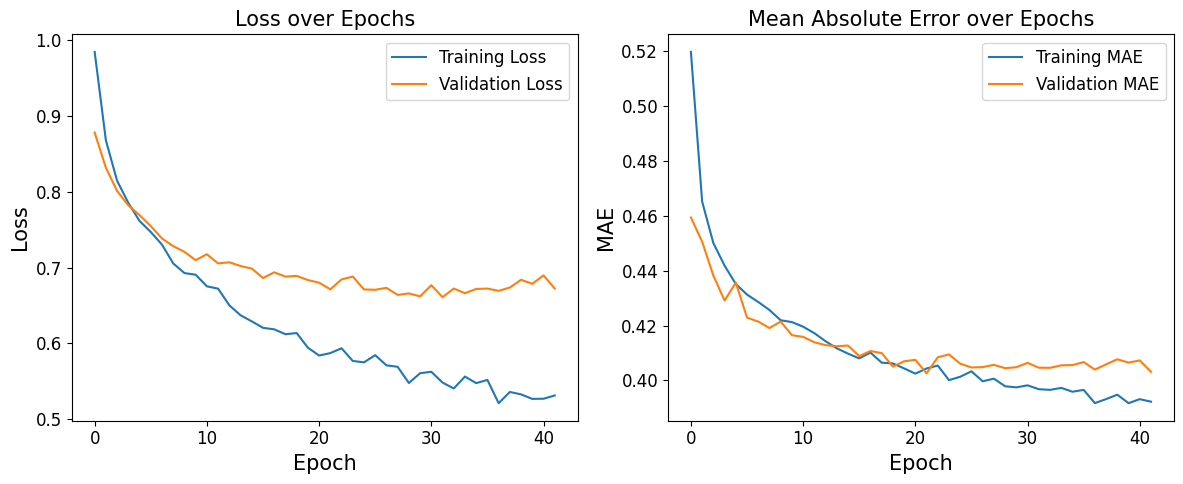

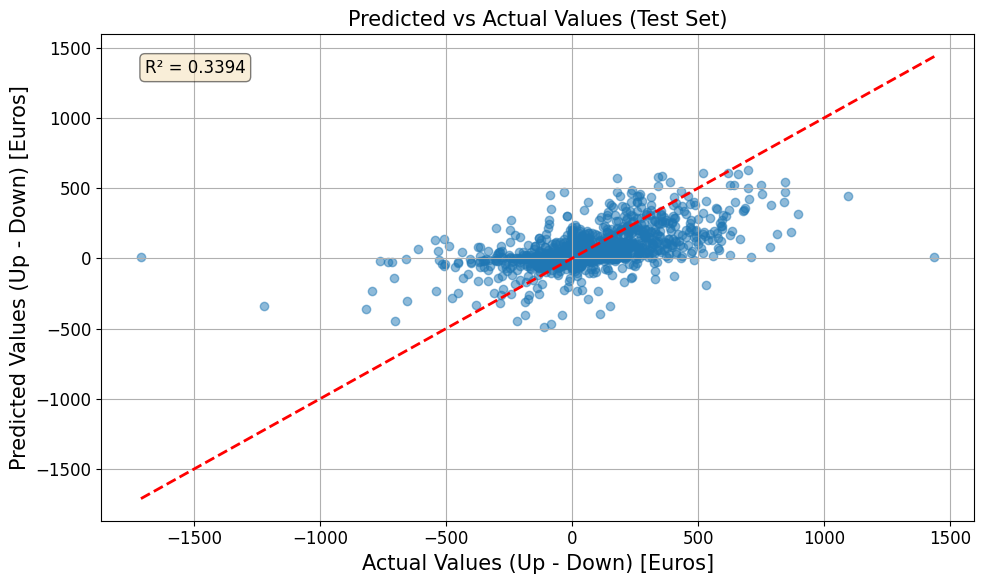

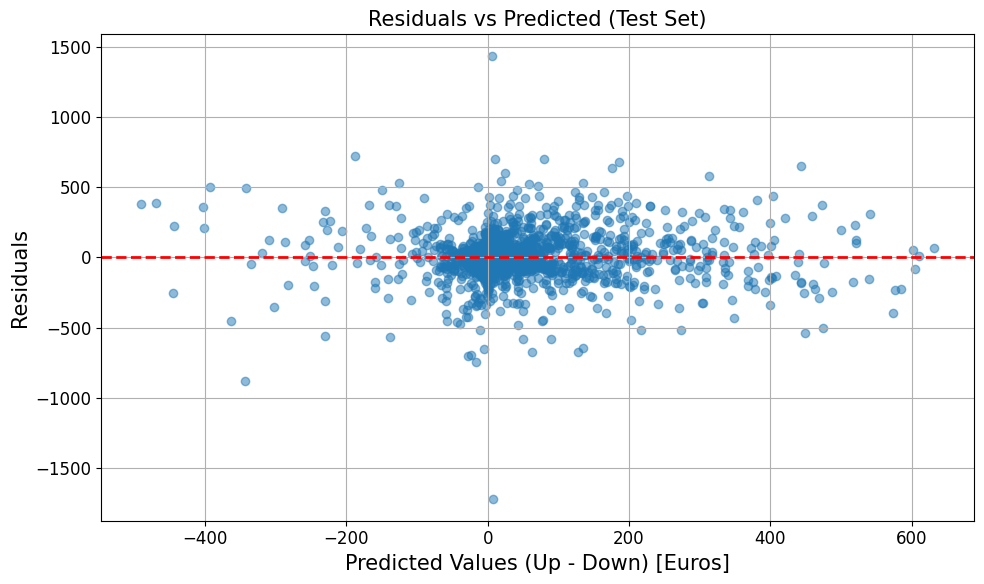

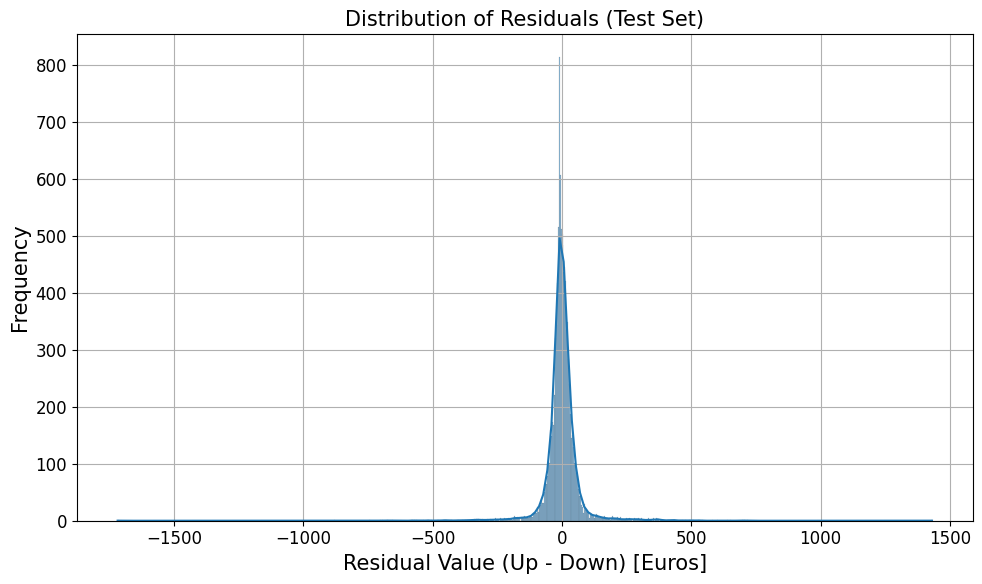

In [ ]:
def train_deep_learning_model(target_values, parameter_df, train_percentage=0.7,
                              validation_percentage=0.15, epochs=100, batch_size=32,
                              hidden_layers=[64, 32], dropout_rate=0.2, patience=10):
    """
    Train a deep learning model using numpy array targets and DataFrame parameters.

    Parameters:
    -----------
    target_values : numpy.ndarray
        The values to forecast (target variable)
    parameter_df : pandas.DataFrame
        DataFrame containing the input parameters/features
    train_percentage : float, default=0.7
        Percentage of data to use for training (between 0 and 1)
    validation_percentage : float, default=0.15
        Percentage of data to use for validation (between 0 and 1)
        Test percentage will be automatically calculated as (1 - train_percentage - validation_percentage)
    epochs : int, default=100
        Number of training epochs
    batch_size : int, default=32
        Batch size for training
    hidden_layers : list of int, default=[64, 32]
        Number of neurons in each hidden layer
    dropout_rate : float, default=0.2
        Dropout rate for regularization
    patience : int, default=10
        Number of epochs with no improvement after which training will stop

    Returns:
    --------
    model : tensorflow.keras.models.Sequential
        The trained model
    history : tensorflow.keras.callbacks.History
        Training history
    test_metrics : dict
        Dictionary with various performance metrics on test data
    performance_plots : dict
        Dictionary with figure objects for performance visualizations
    X_scaler : sklearn.preprocessing.StandardScaler
        Fitted feature scaler for future use
    y_scaler : sklearn.preprocessing.StandardScaler
        Fitted target scaler for future use
    """
    # Validate inputs
    if not isinstance(target_values, np.ndarray):
        raise TypeError("target_values must be a numpy array")

    if not isinstance(parameter_df, pd.DataFrame):
        raise TypeError("parameter_df must be a pandas DataFrame")

    if train_percentage <= 0 or train_percentage >= 1:
        raise ValueError("train_percentage must be between 0 and 1")

    if validation_percentage <= 0 or validation_percentage >= 1:
        raise ValueError("validation_percentage must be between 0 and 1")

    # Calculate test percentage automatically
    test_percentage = 1 - train_percentage - validation_percentage

    if test_percentage <= 0:
        raise ValueError(f"The sum of train_percentage ({train_percentage}) and validation_percentage ({validation_percentage}) must be less than 1. Current test percentage: {test_percentage}")

    print(f"Data split: Training {train_percentage*100:.1f}%, Validation {validation_percentage*100:.1f}%, Test {test_percentage*100:.1f}%")

    # Store figures for return
    performance_plots = {}

    # Convert target to 2D if it's 1D
    if len(target_values.shape) == 1:
        target_values = target_values.reshape(-1, 1)

    # Standardize features and target
    X_scaler = StandardScaler()
    y_scaler = StandardScaler()

    X = X_scaler.fit_transform(parameter_df)
    y = y_scaler.fit_transform(target_values)

    # Save original y values for later evaluation
    y_original = target_values.copy()

    # Split data into train, validation, and test sets
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y, test_size=test_percentage, random_state=42
    )

    # Save original test values for later evaluation
    y_test_original = y_scaler.inverse_transform(y_test)

    # Calculate validation percentage relative to the train_val set
    relative_val_percentage = validation_percentage / (train_percentage + validation_percentage)

    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val,
        test_size=relative_val_percentage,
        random_state=42
    )

    # Verify split proportions
    print(f"Actual split sizes: Training {len(X_train)}, Validation {len(X_val)}, Test {len(X_test)}")
    print(f"Actual split percentages: Training {len(X_train)/len(X):.1%}, Validation {len(X_val)/len(X):.1%}, Test {len(X_test)/len(X):.1%}")

    # Build the model
    model = Sequential()

    # Input layer
    model.add(Dense(hidden_layers[0], activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dropout(dropout_rate))

    # Hidden layers
    for units in hidden_layers[1:]:
        model.add(Dense(units, activation='relu'))
        model.add(Dropout(dropout_rate))

    # Output layer - number of neurons matches target dimensions
    model.add(Dense(y_train.shape[1]))

    # Compile the model
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    # Early stopping to prevent overfitting
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=patience,
        restore_best_weights=True
    )

    # Train the model
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping],
        verbose=1
    )

    # Plot training history
    fig_history = plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs', fontsize=15)
    plt.xlabel('Epoch', fontsize=15)
    plt.ylabel('Loss', fontsize=15)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Training MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title('Mean Absolute Error over Epochs', fontsize=15)
    plt.xlabel('Epoch', fontsize=15)
    plt.ylabel('MAE', fontsize=15)
    plt.legend()

    plt.tight_layout()
    performance_plots['training_history'] = fig_history

    # ------ Comprehensive Test Performance Evaluation ------
    # Make predictions on test data
    y_test_pred_scaled = model.predict(X_test)

    # Convert predictions back to original scale
    y_test_pred = y_scaler.inverse_transform(y_test_pred_scaled)

    # Calculate performance metrics (on original scale)
    test_metrics = {}

    # For each target dimension (in case of multi-output prediction)
    for i in range(y_test_original.shape[1]):
        dim_suffix = f"_dim{i}" if y_test_original.shape[1] > 1 else ""

        # Calculate metrics
        test_metrics[f'mse{dim_suffix}'] = mean_squared_error(y_test_original[:, i], y_test_pred[:, i])
        test_metrics[f'rmse{dim_suffix}'] = np.sqrt(test_metrics[f'mse{dim_suffix}'])
        test_metrics[f'mae{dim_suffix}'] = mean_absolute_error(y_test_original[:, i], y_test_pred[:, i])
        test_metrics[f'r2{dim_suffix}'] = r2_score(y_test_original[:, i], y_test_pred[:, i])

        # Calculate mean absolute percentage error, handling zeros carefully
        y_true = y_test_original[:, i]
        y_pred = y_test_pred[:, i]
        mask = y_true != 0  # Avoid division by zero
        if np.any(mask):
            mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
            test_metrics[f'mape{dim_suffix}'] = mape
        else:
            test_metrics[f'mape{dim_suffix}'] = np.nan

    # Print performance metrics
    print("\n----- Test Performance Metrics -----")
    for metric, value in test_metrics.items():
        print(f"{metric}: {value:.4f}")

    # ------ Visualizations of Test Results ------

    # 1. Predicted vs Actual Plot
    fig_pred_vs_actual = plt.figure(figsize=(10, 6))
    target_dim = 0  # Default to first dimension if multi-output

    plt.scatter(y_test_original[:, target_dim], y_test_pred[:, target_dim], alpha=0.5)
    plt.plot([y_test_original[:, target_dim].min(), y_test_original[:, target_dim].max()],
             [y_test_original[:, target_dim].min(), y_test_original[:, target_dim].max()],
             'r--', lw=2)
    plt.title('Predicted vs Actual Values (Test Set)', fontsize=15)
    plt.xlabel('Actual Values (Up - Down) [Euros]', fontsize=15)
    plt.ylabel('Predicted Values (Up - Down) [Euros]', fontsize=15)
    plt.grid(True)

    # Add R² value to plot
    r2_text = f"R² = {test_metrics['r2' if y_test_original.shape[1] == 1 else 'r2_dim0']:.4f}"
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    plt.text(0.05, 0.95, r2_text, transform=plt.gca().transAxes, fontsize=12,
            verticalalignment='top', bbox=props)

    plt.tight_layout()
    performance_plots['pred_vs_actual'] = fig_pred_vs_actual

    # 2. Residuals Plot
    fig_residuals = plt.figure(figsize=(10, 6))
    residuals = y_test_original[:, target_dim] - y_test_pred[:, target_dim]

    plt.scatter(y_test_pred[:, target_dim], residuals, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--', lw=2)
    plt.title('Residuals vs Predicted (Test Set)', fontsize=15)
    plt.xlabel('Predicted Values (Up - Down) [Euros]', fontsize=15)
    plt.ylabel('Residuals', fontsize=15)
    plt.grid(True)

    plt.tight_layout()
    performance_plots['residuals'] = fig_residuals

    # 3. Residuals Distribution
    fig_residual_dist = plt.figure(figsize=(10, 6))
    sns.histplot(residuals, kde=True)
    plt.title('Distribution of Residuals (Test Set)', fontsize=15)
    plt.xlabel('Residual Value (Up - Down) [Euros]', fontsize=15)
    plt.ylabel('Frequency', fontsize=15)
    plt.grid(True)

    plt.tight_layout()
    performance_plots['residual_dist'] = fig_residual_dist

    # 4. Error Distribution (as percentage of actual value)
    # if y_test_original.shape[1] == 1:  # Only for single output for simplicity
    #     fig_pct_error = plt.figure(figsize=(10, 6))

    #     # Calculate percentage error, avoiding division by zero
    #     mask = y_test_original[:, 0] != 0
    #     pct_errors = np.zeros_like(y_test_original[:, 0])
    #     pct_errors[mask] = ((y_test_pred[:, 0][mask] - y_test_original[:, 0][mask]) / y_test_original[:, 0][mask]) * 100

    #     sns.histplot(pct_errors[mask], kde=True)
    #     plt.title('Percentage Error Distribution (Test Set)')
    #     plt.xlabel('Percentage Error')
    #     plt.ylabel('Frequency')
    #     plt.axvline(x=0, color='r', linestyle='--', lw=2)
    #     plt.grid(True)

    #     plt.tight_layout()
    #     performance_plots['pct_error_dist'] = fig_pct_error

    # # Show plots in interactive mode
    # plt.show()

    return model, history, test_metrics, performance_plots, X_scaler, y_scaler


def predict_with_model(model, new_data, X_scaler, y_scaler):
    """
    Make predictions using the trained model.

    Parameters:
    -----------
    model : tensorflow.keras.models.Sequential
        The trained model
    new_data : pandas.DataFrame
        New data to make predictions on (should have the same features as the training data)
    X_scaler : sklearn.preprocessing.StandardScaler
        Fitted feature scaler from training
    y_scaler : sklearn.preprocessing.StandardScaler
        Fitted target scaler from training

    Returns:
    --------
    predictions : numpy.ndarray
        The predicted values in the original scale
    """
    # Scale the input features
    X_new = X_scaler.transform(new_data)

    # Make predictions
    y_pred_scaled = model.predict(X_new)

    # Inverse transform to get the original scale
    predictions = y_scaler.inverse_transform(y_pred_scaled)

    return predictions


# Usage example:
if __name__ == "__main__":

    model, history, test_metrics, performance_plots, X_scaler, y_scaler = train_deep_learning_model(
        dif_up_down, df_clean.iloc[:, 2:-2], train_percentage=0.55, validation_percentage=0.15
    )

    # Print a summary of all test metrics
    print("\n===== Test Performance Summary =====")
    for metric_name, metric_value in test_metrics.items():
        print(f"{metric_name}: {metric_value:.4f}")

    # Make predictions with new data
    predictions_deep_learning = predict_with_model(model, df_clean.iloc[:, 2:-2].iloc[int(len(df) * 0.7):], X_scaler, y_scaler)

    # print("\nSample Predictions:")
    # print(predictions)

## Classification performance

In [ ]:
def analyze_classification(test_data: np.ndarray, predictions: np.ndarray) -> Tuple[Dict, Dict, pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Analyze classification performance based on sign matching.

    Args:
        test_data: Array of true values
        predictions: Array of predicted values

    Returns:
        Tuple containing:
        - Hourly performance metrics
        - Performance by percentile
        - DataFrame with all results
        - Cross-tabulation of hour vs percentile performance
        - Sample counts for each hour-percentile combination
    """
    # Ensure inputs are numpy arrays
    test_data = np.array(test_data)
    predictions = np.array(predictions)

    if len(test_data) != len(predictions):
        raise ValueError("Test data and predictions must have the same length")

    # Create DataFrame for analysis
    df = pd.DataFrame({
        'hour': [(i % 24) + 1 for i in range(len(test_data))],  # 1-24 hour format
        'test': test_data,
        'pred': predictions
    })

    # Filter out test values of 0
    df = df[df['test'] != 0].copy()

    # Add classification result
    df['correct'] = (np.sign(df['test']) == np.sign(df['pred']))

    # Analysis by hour
    hourly_performance = {}
    for hour in range(1, 25):
        hour_df = df[df['hour'] == hour]
        if len(hour_df) > 0:
            accuracy = hour_df['correct'].mean()
            hourly_performance[hour] = {
                'accuracy': accuracy,
                'count': len(hour_df),
                'correct': hour_df['correct'].sum()
            }
        else:
            hourly_performance[hour] = {'accuracy': np.nan, 'count': 0, 'correct': 0}

    # Analysis by percentile of prediction magnitude
    # Calculate percentiles of absolute prediction values
    df['abs_pred'] = np.abs(df['pred'])

    # Create percentile bins
    try:
        # Try to use qcut for equal-sized percentile bins
        df['percentile'] = pd.qcut(df['abs_pred'], q=[0, 0.1, 0.25, 0.5, 0.75, 0.9, 1.0],
                                  labels=['0-10', '10-25', '25-50', '50-75', '75-90', '90-100'])
    except ValueError:
        # Fall back to cut if qcut fails (e.g., due to ties)
        percentile_edges = np.percentile(df['abs_pred'], [0, 10, 25, 50, 75, 90, 100])
        df['percentile'] = pd.cut(df['abs_pred'], bins=percentile_edges,
                                 labels=['0-10', '10-25', '25-50', '50-75', '75-90', '90-100'],
                                 include_lowest=True)

    # Group performance by percentile buckets
    percentile_ranges = ['0-10', '10-25', '25-50', '50-75', '75-90', '90-100']
    percentile_performance = {}

    for percentile_range in percentile_ranges:
        bucket_df = df[df['percentile'] == percentile_range]
        if len(bucket_df) > 0:
            accuracy = bucket_df['correct'].mean()
            percentile_performance[percentile_range] = {
                'accuracy': accuracy,
                'count': len(bucket_df),
                'correct': bucket_df['correct'].sum()
            }
        else:
            percentile_performance[percentile_range] = {'accuracy': np.nan, 'count': 0, 'correct': 0}

    # Create cross-tabulation of hour vs percentile
    # Initialize with NaN values
    hour_percentile_table = pd.DataFrame(np.nan, index=range(1, 25), columns=percentile_ranges)
    hour_percentile_counts = pd.DataFrame(0, index=range(1, 25), columns=percentile_ranges)

    # Fill in the tables with actual data
    for hour in range(1, 25):
        for percentile_range in percentile_ranges:
            subset = df[(df['hour'] == hour) & (df['percentile'] == percentile_range)]
            if len(subset) > 0:
                hour_percentile_table.loc[hour, percentile_range] = subset['correct'].mean()
                hour_percentile_counts.loc[hour, percentile_range] = len(subset)

    return hourly_performance, percentile_performance, df, hour_percentile_table, hour_percentile_counts

def plot_results(hourly_performance: Dict, percentile_performance: Dict) -> None:
    """Plot the classification performance by hour and percentile"""
    plt.figure(figsize=(12, 10))

    # Plot 1: Hourly performance
    plt.subplot(2, 1, 1)
    hours = list(hourly_performance.keys())
    accuracies = [hourly_performance[h]['accuracy'] for h in hours]
    counts = [hourly_performance[h]['count'] for h in hours]

    # Create a color map for the bar chart
    colors = []
    for acc in accuracies:
        if np.isnan(acc):
            colors.append('lightgray')
        else:
            r = max(0, min(1, 2 * (1 - acc)))
            g = max(0, min(1, 2 * acc))
            colors.append((r, g, 0))

    plt.bar(hours, accuracies, alpha=0.7, color=colors)
    plt.title('Classification Accuracy by Hour', fontsize=17)
    plt.xlabel('Hour of Day', fontsize=15)
    plt.ylabel('Accuracy', fontsize=15)
    plt.xticks(range(1, 25))
    plt.ylim(0, 1)
    plt.grid(True, alpha=0.3)

    for i, (hour, acc, count) in enumerate(zip(hours, accuracies, counts)):
        if not np.isnan(acc):
            plt.text(hour, acc + 0.02, f"n={count}", ha='center', fontsize=8)

    # Plot 2: Percentile performance
    plt.subplot(2, 1, 2)
    percentiles = list(percentile_performance.keys())
    p_accuracies = [percentile_performance[p]['accuracy'] for p in percentiles]
    p_counts = [percentile_performance[p]['count'] for p in percentiles]

    # Create colors for percentile bars
    p_colors = []
    for acc in p_accuracies:
        if np.isnan(acc):
            p_colors.append('lightgray')
        else:
            r = max(0, min(1, 2 * (1 - acc)))
            g = max(0, min(1, 2 * acc))
            p_colors.append((r, g, 0))

    plt.bar(range(len(percentiles)), p_accuracies, alpha=0.7, color=p_colors)
    plt.title('Classification Accuracy by Prediction Percentile', fontsize=17)
    plt.xlabel('Percentile Range', fontsize=15)
    plt.ylabel('Accuracy', fontsize=15)
    plt.ylim(0, 1)
    plt.grid(True, alpha=0.3)
    plt.xticks(range(len(percentiles)), percentiles, rotation=45)

    for i, (_, acc, count) in enumerate(zip(percentiles, p_accuracies, p_counts)):
        if not np.isnan(acc):
            plt.text(i, acc + 0.02, f"n={count}", ha='center', fontsize=8)

    plt.tight_layout()
    plt.show()


def plot_optimized_heatmap(hour_percentile_table: pd.DataFrame, hour_percentile_counts: pd.DataFrame) -> None:
    """Create an optimized standalone heatmap with improved visualization"""
    plt.figure(figsize=(14, 10))

    # Make sure we're working with numeric data
    heatmap_data = hour_percentile_table.astype(float)

    # Create custom red to green colormap
    red_green_cmap = LinearSegmentedColormap.from_list("red_to_green", [(0.9, 0, 0), (1, 0.7, 0), (0, 0.7, 0)])

    # Create annotation text
    annot_text = np.empty_like(heatmap_data, dtype=object)
    for i, row in enumerate(hour_percentile_table.index):
        for j, col in enumerate(hour_percentile_table.columns):
            acc = hour_percentile_table.loc[row, col]
            count = hour_percentile_counts.loc[row, col]
            if pd.notna(acc):
                annot_text[i, j] = f"{acc:.2f}\n({count})"
            else:
                annot_text[i, j] = "N/A"

    # Create the heatmap with optimized settings
    fig, ax = plt.subplots(figsize=(14, 10))

    # Plot the heatmap
    sns.heatmap(heatmap_data, ax=ax, cmap=red_green_cmap, vmin=0, vmax=1,
                annot=False, linewidths=0.5, linecolor='white', cbar_kws={'label': 'Accuracy'})

    # Add text annotations manually for better control
    for i in range(len(hour_percentile_table.index)):
        for j in range(len(hour_percentile_table.columns)):
            acc = heatmap_data.iloc[i, j]
            count = hour_percentile_counts.iloc[i, j]

            if pd.notna(acc):
                # Choose text color based on background
                text_color = 'black' if 0.3 <= acc <= 0.7 else 'white'

                # Add accuracy value
                ax.text(j + 0.5, i + 0.35, f"{acc:.2f}",
                        ha="center", va="center", fontsize=10,
                        color=text_color, fontweight='bold')

                # Add count below
                ax.text(j + 0.5, i + 0.65, f"({count})",
                        ha="center", va="center", fontsize=9,
                        color=text_color)
            else:
                ax.text(j + 0.5, i + 0.5, f"N/A\n({count})",
                        ha="center", va="center", fontsize=9,
                        color='black')

    # Set title and labels
    ax.set_title('Classification Accuracy by Hour and Percentile', fontsize=16, pad=10)
    ax.set_xlabel('Prediction Magnitude Percentile', fontsize=14)
    ax.set_ylabel('Hour of Day', fontsize=14)

    # Ensure proper alignment of labels
    plt.tight_layout()
    plt.show()

def create_styled_dataframe(hour_percentile_table: pd.DataFrame, hour_percentile_counts: pd.DataFrame) -> pd.DataFrame:
    """Create a styled DataFrame for display with counts in parentheses"""
    # Create a new DataFrame with formatted values: accuracy (count)
    styled_df = pd.DataFrame(index=hour_percentile_table.index, columns=hour_percentile_table.columns)

    for idx in hour_percentile_table.index:
        for col in hour_percentile_table.columns:
            acc = hour_percentile_table.loc[idx, col]
            count = hour_percentile_counts.loc[idx, col]

            if pd.notna(acc):
                styled_df.loc[idx, col] = f"{acc:.2f} ({count})"
            else:
                styled_df.loc[idx, col] = f"N/A ({count})"

    return styled_df

# Example usage
def run_example():
    # Generate sample data
    np.random.seed(42)
    days = 30
    hours_per_day = 24
    test_data = np.random.normal(0, 1, days * hours_per_day)

    # Make predictions have some correlation with test data but with noise
    predictions = test_data * 0.7 + np.random.normal(0, 0.7, days * hours_per_day)

    # Add some time-of-day pattern (better predictions during business hours)
    hour_indices = np.array([(i % 24) for i in range(len(test_data))])
    business_hours = (hour_indices >= 9) & (hour_indices <= 17)
    predictions[business_hours] = test_data[business_hours] * 0.9 + np.random.normal(0, 0.4, np.sum(business_hours))

    # Set some values to zero in test data (to be excluded)
    test_data[np.random.choice(len(test_data), size=100)] = 0

    # Run analysis
    hourly_perf, percentile_perf, results_df, hour_percentile_table, hour_percentile_counts = analyze_classification(test_data, predictions)

    # Print results
    print("Hourly Classification Performance:")
    for hour, metrics in hourly_perf.items():
        if metrics['count'] > 0:
            print(f"Hour {hour}: Accuracy = {metrics['accuracy']:.4f} ({metrics['correct']}/{metrics['count']})")

    print("\nPercentile Classification Performance:")
    for perc, metrics in percentile_perf.items():
        if metrics['count'] > 0:
            print(f"Percentile {perc}: Accuracy = {metrics['accuracy']:.4f} ({metrics['correct']}/{metrics['count']})")

    # Show hour vs percentile table
    print("\nHour vs Percentile Performance Table:")
    styled_df = create_styled_dataframe(hour_percentile_table, hour_percentile_counts)
    print(styled_df)

    # Plot optimized heatmap
    plot_optimized_heatmap(hour_percentile_table, hour_percentile_counts)

    # Plot all results
    plot_results(hourly_perf, percentile_perf, hour_percentile_table, hour_percentile_counts)

    return hourly_perf, percentile_perf, results_df, hour_percentile_table, hour_percentile_counts

# if __name__ == "__main__":
#     run_example()

### Lasso

25
Hourly Classification Performance:
Hour 1: Accuracy = 0.5891 (248/421)
Hour 2: Accuracy = 0.5935 (254/428)
Hour 3: Accuracy = 0.6331 (264/417)
Hour 4: Accuracy = 0.6565 (279/425)
Hour 5: Accuracy = 0.5938 (250/421)
Hour 6: Accuracy = 0.6355 (265/417)
Hour 7: Accuracy = 0.5976 (245/410)
Hour 8: Accuracy = 0.6324 (258/408)
Hour 9: Accuracy = 0.6359 (269/423)
Hour 10: Accuracy = 0.6238 (267/428)
Hour 11: Accuracy = 0.5644 (241/427)
Hour 12: Accuracy = 0.5825 (240/412)
Hour 13: Accuracy = 0.6000 (258/430)
Hour 14: Accuracy = 0.5816 (246/423)
Hour 15: Accuracy = 0.6148 (257/418)
Hour 16: Accuracy = 0.6414 (279/435)
Hour 17: Accuracy = 0.6005 (254/423)
Hour 18: Accuracy = 0.6651 (284/427)
Hour 19: Accuracy = 0.6690 (285/426)
Hour 20: Accuracy = 0.6047 (257/425)
Hour 21: Accuracy = 0.5977 (257/430)
Hour 22: Accuracy = 0.6127 (261/426)
Hour 23: Accuracy = 0.5627 (229/407)
Hour 24: Accuracy = 0.6130 (255/416)

Percentile Classification Performance:
Percentile 0-10: Accuracy = 0.4808 (487/101

<Figure size 1400x1000 with 0 Axes>

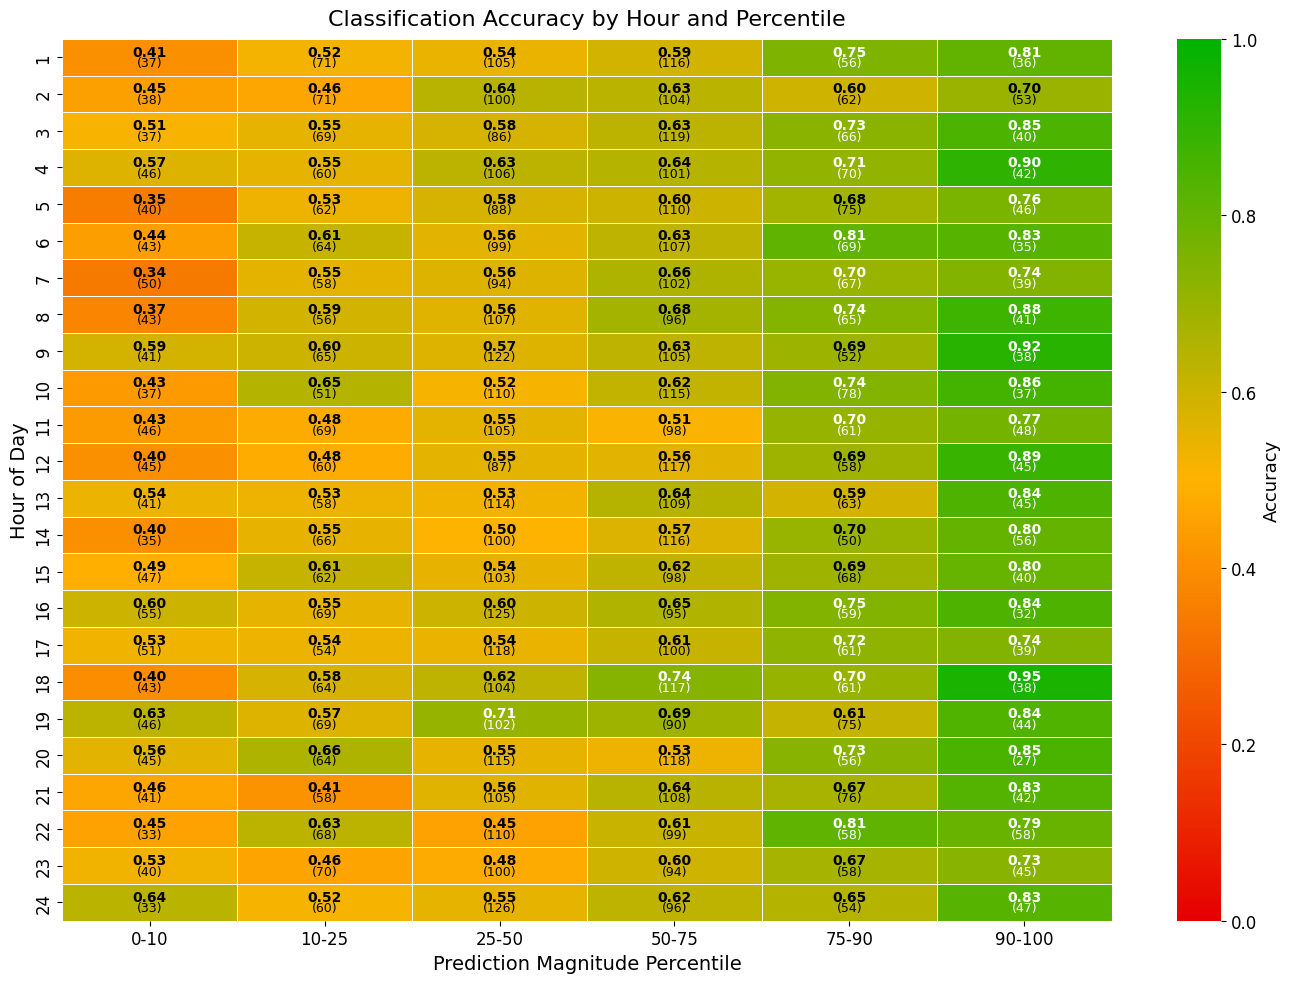

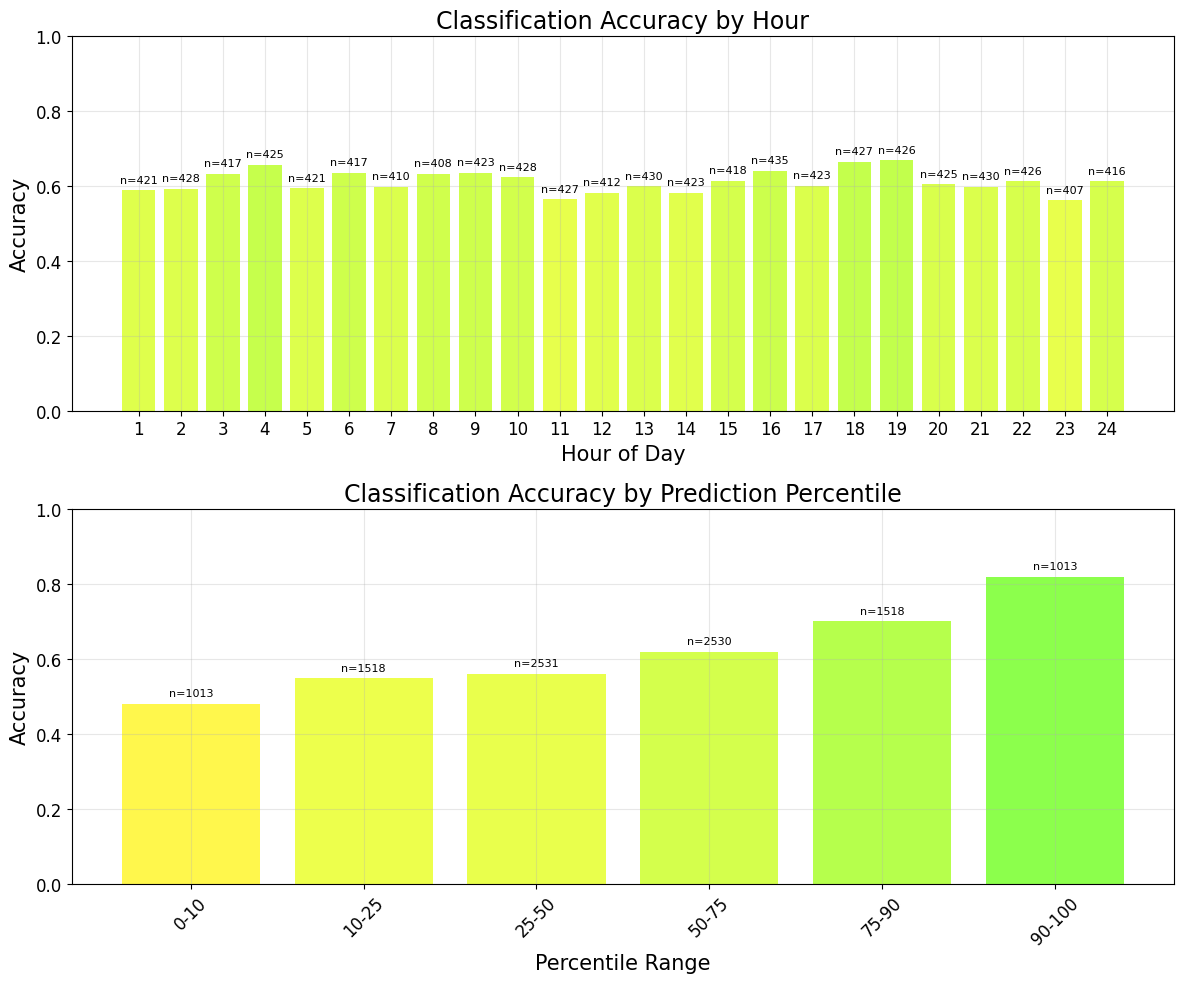

In [ ]:
print(np.array(df_clean['Hour'])[-len(real_lasso)]+10)

# Run analysis
hourly_perf, percentile_perf, results_df, hour_percentile_table, hour_percentile_counts = analyze_classification(real_lasso[10:], predictions_lasso[10:])

# Print results
print("Hourly Classification Performance:")
for hour, metrics in hourly_perf.items():
    if metrics['count'] > 0:
        print(f"Hour {hour}: Accuracy = {metrics['accuracy']:.4f} ({metrics['correct']}/{metrics['count']})")

print("\nPercentile Classification Performance:")
for perc, metrics in percentile_perf.items():
    if metrics['count'] > 0:
        print(f"Percentile {perc}: Accuracy = {metrics['accuracy']:.4f} ({metrics['correct']}/{metrics['count']})")

# Show hour vs percentile table
print("\nHour vs Percentile Performance Table:")
styled_df = create_styled_dataframe(hour_percentile_table, hour_percentile_counts)
print(styled_df)

# Plot optimized heatmap
plot_optimized_heatmap(hour_percentile_table, hour_percentile_counts)

# Plot all results
plot_results(hourly_perf, percentile_perf) #, hour_percentile_table, hour_percentile_counts)



### Bayessian

Hourly Classification Performance:
Hour 1: Accuracy = 0.5938 (250/421)
Hour 2: Accuracy = 0.5958 (255/428)
Hour 3: Accuracy = 0.6379 (266/417)
Hour 4: Accuracy = 0.6518 (277/425)
Hour 5: Accuracy = 0.5962 (251/421)
Hour 6: Accuracy = 0.6427 (268/417)
Hour 7: Accuracy = 0.6049 (248/410)
Hour 8: Accuracy = 0.6373 (260/408)
Hour 9: Accuracy = 0.6430 (272/423)
Hour 10: Accuracy = 0.6285 (269/428)
Hour 11: Accuracy = 0.5738 (245/427)
Hour 12: Accuracy = 0.5874 (242/412)
Hour 13: Accuracy = 0.6000 (258/430)
Hour 14: Accuracy = 0.5863 (248/423)
Hour 15: Accuracy = 0.6244 (261/418)
Hour 16: Accuracy = 0.6414 (279/435)
Hour 17: Accuracy = 0.6028 (255/423)
Hour 18: Accuracy = 0.6698 (286/427)
Hour 19: Accuracy = 0.6667 (284/426)
Hour 20: Accuracy = 0.6071 (258/425)
Hour 21: Accuracy = 0.6023 (259/430)
Hour 22: Accuracy = 0.6080 (259/426)
Hour 23: Accuracy = 0.5676 (231/407)
Hour 24: Accuracy = 0.6082 (253/416)

Percentile Classification Performance:
Percentile 0-10: Accuracy = 0.5133 (520/1013)


<Figure size 1400x1000 with 0 Axes>

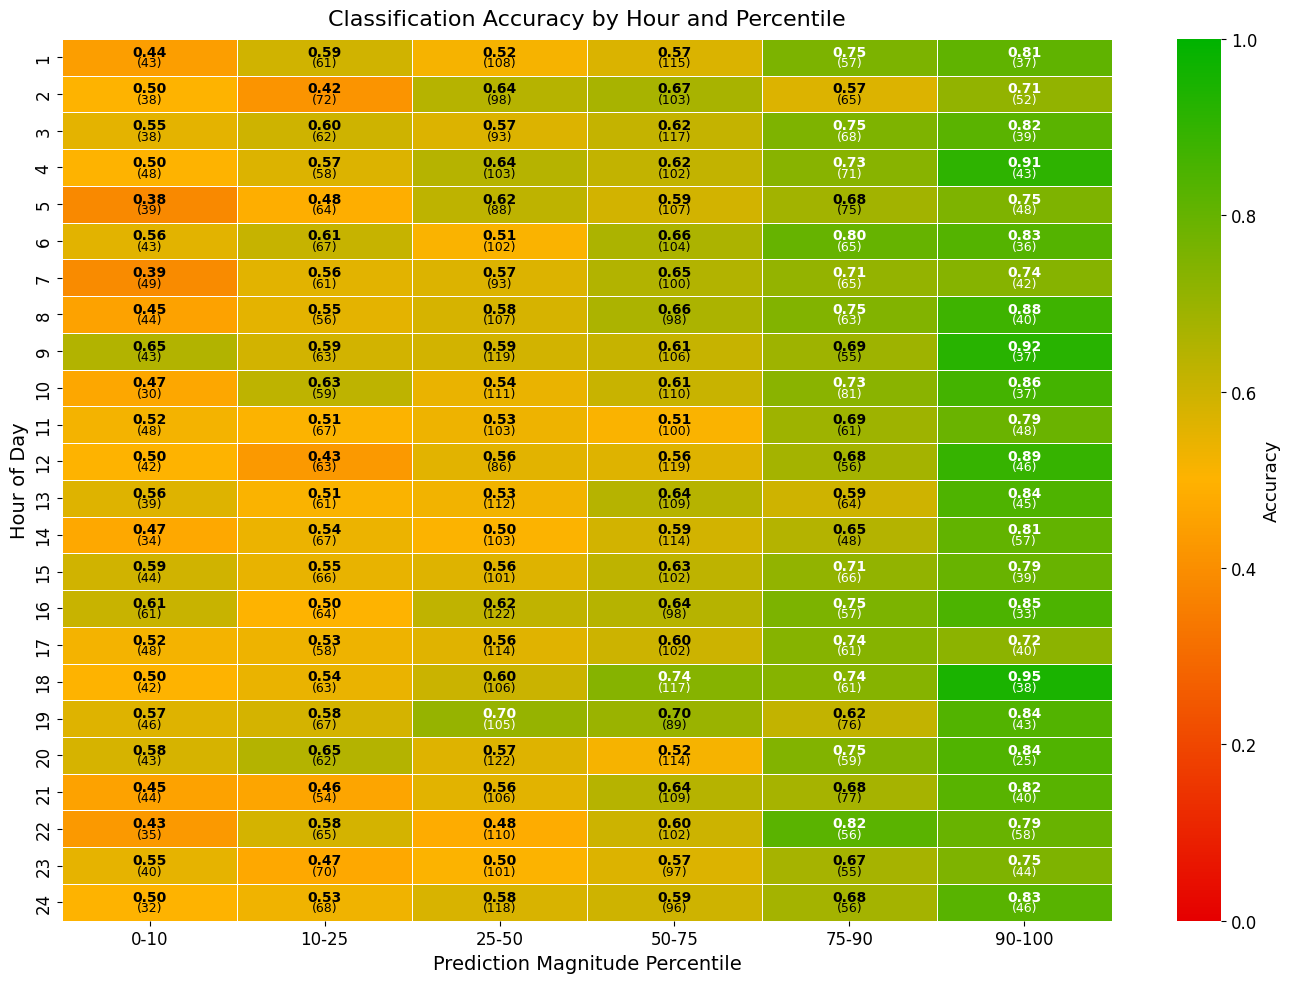

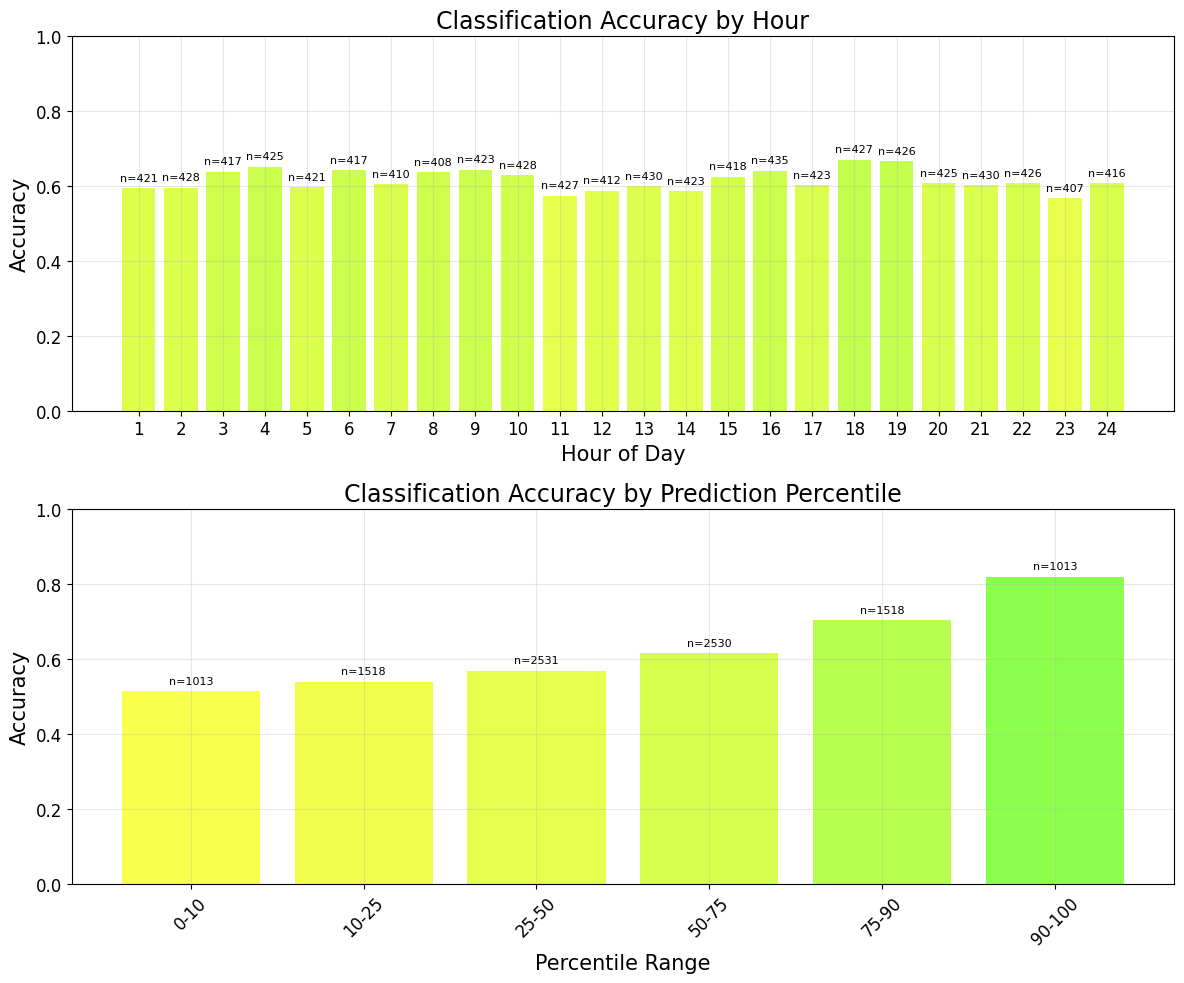

In [ ]:
# Run analysis
hourly_perf, percentile_perf, results_df, hour_percentile_table, hour_percentile_counts = analyze_classification(real_bayes[10:], predictions_bayes[10:])

# Print results
print("Hourly Classification Performance:")
for hour, metrics in hourly_perf.items():
    if metrics['count'] > 0:
        print(f"Hour {hour}: Accuracy = {metrics['accuracy']:.4f} ({metrics['correct']}/{metrics['count']})")

print("\nPercentile Classification Performance:")
for perc, metrics in percentile_perf.items():
    if metrics['count'] > 0:
        print(f"Percentile {perc}: Accuracy = {metrics['accuracy']:.4f} ({metrics['correct']}/{metrics['count']})")

# Show hour vs percentile table
print("\nHour vs Percentile Performance Table:")
styled_df = create_styled_dataframe(hour_percentile_table, hour_percentile_counts)
print(styled_df)

# Plot optimized heatmap
plot_optimized_heatmap(hour_percentile_table, hour_percentile_counts)

# Plot all results
plot_results(hourly_perf, percentile_perf) #, hour_percentile_table, hour_percentile_counts)

### Deep Learning

Hourly Classification Performance:
Hour 1: Accuracy = 0.7102 (326/459)
Hour 2: Accuracy = 0.7867 (354/450)
Hour 3: Accuracy = 0.8200 (360/439)
Hour 4: Accuracy = 0.8491 (377/444)
Hour 5: Accuracy = 0.8242 (375/455)
Hour 6: Accuracy = 0.8684 (132/152)
Hour 7: Accuracy = 0.7133 (214/300)
Hour 8: Accuracy = 0.7397 (324/438)
Hour 9: Accuracy = 0.6925 (295/426)
Hour 10: Accuracy = 0.6626 (273/412)
Hour 11: Accuracy = 0.6172 (258/418)
Hour 12: Accuracy = 0.6253 (272/435)
Hour 13: Accuracy = 0.7146 (323/452)
Hour 14: Accuracy = 0.7556 (340/450)
Hour 15: Accuracy = 0.7974 (362/454)
Hour 16: Accuracy = 0.7760 (343/442)
Hour 17: Accuracy = 0.7201 (319/443)
Hour 18: Accuracy = 0.6795 (301/443)
Hour 19: Accuracy = 0.6589 (282/428)
Hour 20: Accuracy = 0.6475 (281/434)
Hour 21: Accuracy = 0.6706 (287/428)
Hour 22: Accuracy = 0.6453 (282/437)
Hour 23: Accuracy = 0.6282 (272/433)
Hour 24: Accuracy = 0.6830 (306/448)

Percentile Classification Performance:
Percentile 0-10: Accuracy = 0.5296 (536/1012)


<Figure size 1400x1000 with 0 Axes>

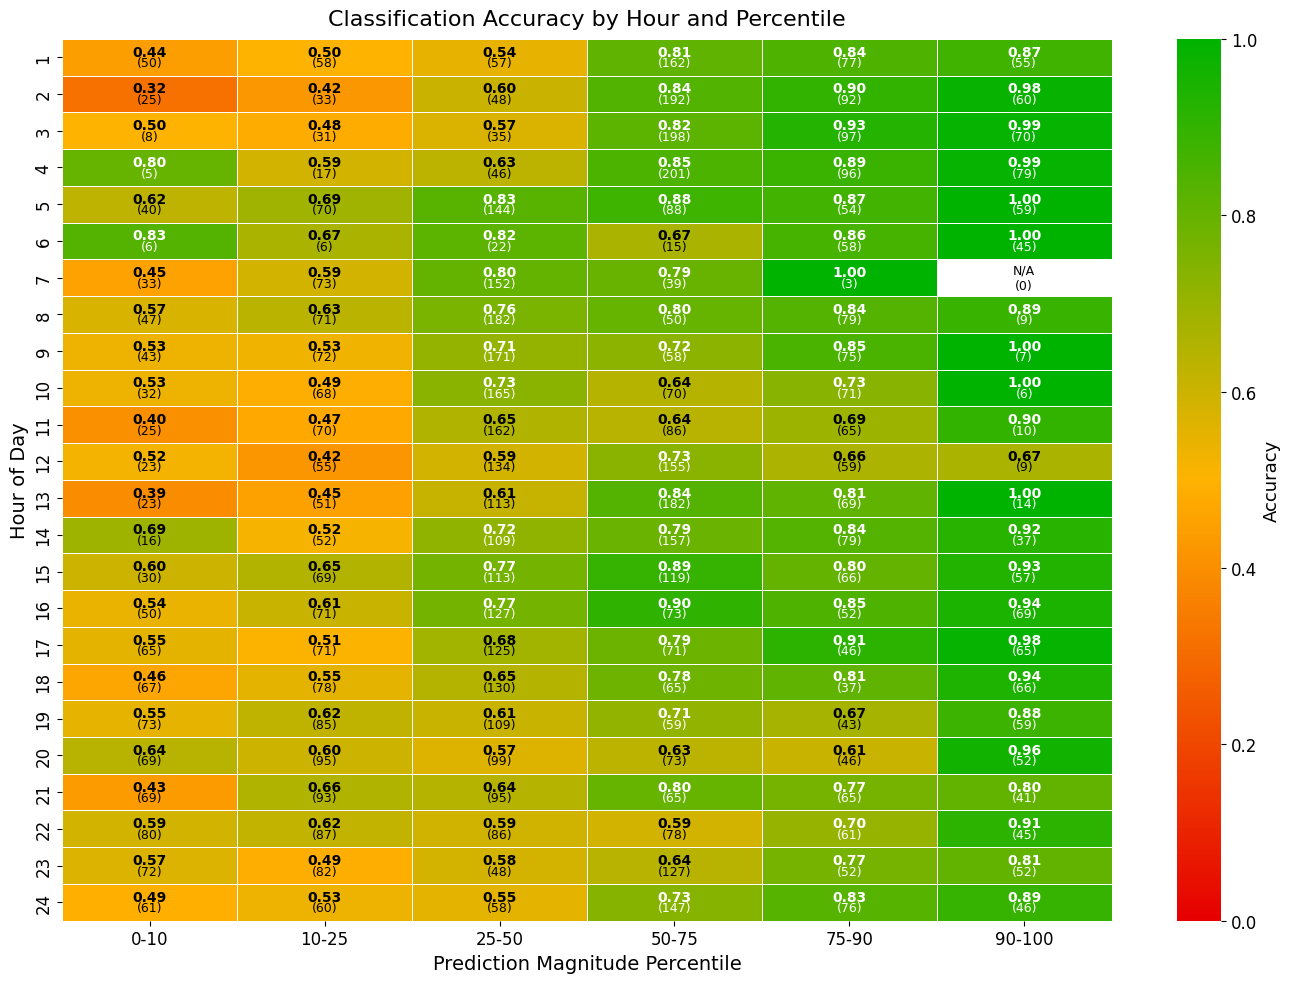

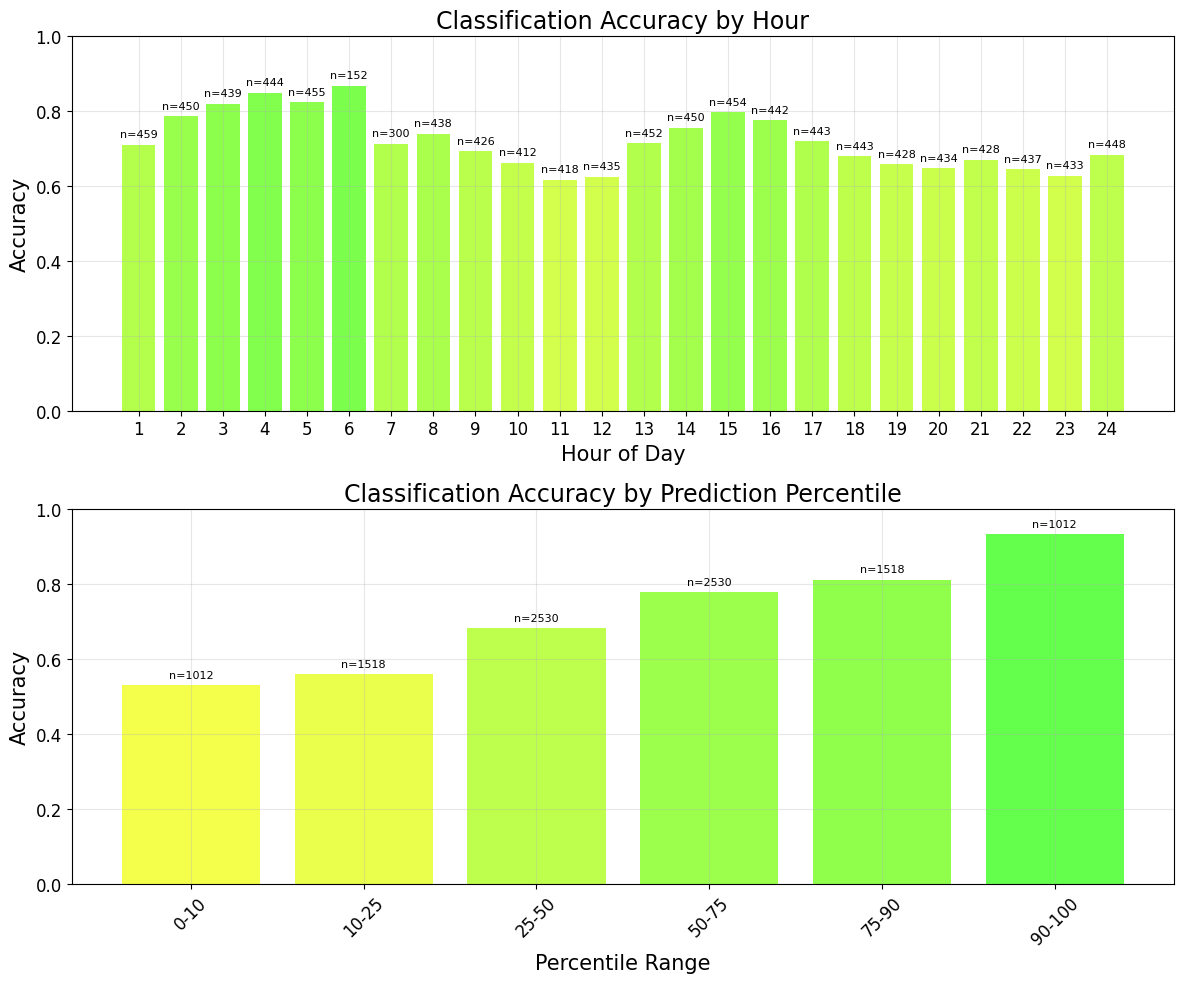

In [ ]:
# Run analysis
hourly_perf, percentile_perf, results_df, hour_percentile_table, hour_percentile_counts = analyze_classification(
    dif_up_down[-len(predictions_deep_learning.transpose()[0][6:]):], predictions_deep_learning.transpose()[0][6:])

# Print results
print("Hourly Classification Performance:")
for hour, metrics in hourly_perf.items():
    if metrics['count'] > 0:
        print(f"Hour {hour}: Accuracy = {metrics['accuracy']:.4f} ({metrics['correct']}/{metrics['count']})")

print("\nPercentile Classification Performance:")
for perc, metrics in percentile_perf.items():
    if metrics['count'] > 0:
        print(f"Percentile {perc}: Accuracy = {metrics['accuracy']:.4f} ({metrics['correct']}/{metrics['count']})")

# Show hour vs percentile table
print("\nHour vs Percentile Performance Table:")
styled_df = create_styled_dataframe(hour_percentile_table, hour_percentile_counts)
print(styled_df)

# Plot optimized heatmap
plot_optimized_heatmap(hour_percentile_table, hour_percentile_counts)

# Plot all results
plot_results(hourly_perf, percentile_perf) #, hour_percentile_table, hour_percentile_counts)